In [7]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, ks_2samp

In [341]:
def df_gen(RESULTS_DIR, NSHARDS=10):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [9]:
def smoothed_plot_perf_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_meas: str,
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (8, 5),
    cmap: str = 'tab10'
):
    """
    Plot smoothed binned performance vs. metric for multiple models,
    with shaded 95% confidence intervals around the mean.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model in `models`,
        a performance column named model+perf_meas (e.g. 'GCN'+'accuracy' → 'GCNaccuracy').
    models : list of str
        Model-name prefixes.
    perf_meas : str
        Performance-measure suffix (e.g. 'f1_macro', 'accuracy').
    metric : str
        The continuous metric to bin (e.g. 'homophily_rate').
    n_bins : int, default=10
        Number of equal-width bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Create equal-width bins and label them by their center values
    bin_edges = np.linspace(df[metric].min(), df[metric].max(), n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)


    # 2. Initialize plot
    plt.figure(figsize=figsize)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))

    # 3. For each model, compute mean and 95% CI in each bin and plot
    for model, color in zip(models, colors):
        col = f"{model}__{perf_meas}"
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        grp = df.groupby('_bin')[col]
        count = grp.count()                    # number of observations per bin
        mean = grp.mean()                      # mean performance per bin
        std  = grp.std(ddof=1)                 # sample standard deviation
        sem  = std / np.sqrt(count)            # standard error of the mean
        ci95 = 1.96 * sem                      

        # Only keep bins with data
        valid = count > 0
        x     = mean.index.astype(float)[valid]
        y     = mean[valid]
        lower = y - ci95[valid]
        upper = y + ci95[valid]

        # Plot mean line and shaded 95% CI
        plt.plot(x, y, label=model, color=color, linewidth=2)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)

    # 4. Final styling
    plt.xlabel(metric)
    plt.ylabel(perf_meas)
    plt.ylim(0,1)
    plt.title(f"{perf_meas} vs {metric} (binned, with 95% CI)")
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True)

In [281]:
def boxplots(df, models, metric, label = None):
    plt.boxplot(df[[f'{model}__{metric}' for model in models]], tick_labels= models, label = label)
    plt.ylabel(f'{metric}')
    plt.title(label)
    plt.show()

In [66]:
def compute_and_plot_graph_metric_correlations(
    df: pd.DataFrame,
    graph_metrics: list,
    models: list,
    perf_suffix: str = "test_f1_macro",
    corr_method: str = "pearson",
    figsize: tuple = (10, 8)
):
    """
    1) Filters df to rows where 'feature_dim' == feature_dim.
    2) For each graph‐metric in graph_metrics, compute its correlation (Pearson or Spearman)
       against each model’s performance column: f"{model}__{perf_suffix}".
    3) Plots the resulting correlation matrix as a heatmap.

    Args:
      df:            The full DataFrame containing your results and graph_metrics.
      graph_metrics: List of column‐names (strings) that describe graph‐level metrics.
      models:        List of model‐prefixes, e.g. ['MLP','GCN','HGCN'].
      perf_suffix:   The suffix of the performance column, e.g. "test_f1_macro".
      corr_method:   "pearson" or "spearman".
      figsize:       Size of the final figure.
    Returns:
      corr_df:       A DataFrame of shape (len(graph_metrics) × len(models)), containing
                     correlation coefficients.
    """

    df16 = df

    # 2) Build an empty DataFrame to hold correlation coefficients
    corr_df = pd.DataFrame(
        index=graph_metrics,
        columns=models,
        dtype=float
    )

    # 3) For each model, for each graph_metric, compute correlation w.r.t. performance
    for model in models:
        perf_col = f"{model}__{perf_suffix}"
        if perf_col not in df16.columns:
            raise KeyError(f"Performance column {perf_col} not found in DataFrame.")

        # We’ll drop NaNs pairwise
        for metric in graph_metrics:
            if metric not in df16.columns:
                raise KeyError(f"Graph‐metric column {metric} not found in DataFrame.")
            sub = df16[[metric, perf_col]].dropna()

            # Now drop any rows where either value is not finite (inf or NaN).
            # (pearsonr / spearmanr require strictly finite inputs.)
            x = sub[metric].values
            y = sub[perf_col].values
            finite_mask = np.isfinite(x) & np.isfinite(y)
            x_finite = x[finite_mask]
            y_finite = y[finite_mask]

            # If fewer than 3 points remain, correlation is not well-defined:
            if x_finite.shape[0] < 3:
                corr_val = np.nan
            else:
                if corr_method == "pearson":
                    corr_val, _ = pearsonr(x_finite, y_finite)
                elif corr_method == "spearman":
                    corr_val, _ = spearmanr(x_finite, y_finite)
                else:
                    raise ValueError("corr_method must be 'pearson' or 'spearman'.")

            corr_df.loc[metric, model] = corr_val

    # 4) Plot a heatmap of those correlation coefficients
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_df.astype(float),
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0.0,
        cbar_kws={"label": f"{corr_method.title()} correlation"}
    )
    plt.title(f"{corr_method.title()} correlations")
    plt.ylabel("Graph‐level metric")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_df

## Generated following "Examining the Effects of Degree Distribution and Homophily in Graph Learning Models" as closely as possible
Same parameter ranges, same training/validation sample size, only SBM, using TPE to hyperparameter search rather than grid search.

In [256]:
NSHARDS = 10
models = ['MLP', 'GCN']
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/sample_gen/'
RESULTS_DIR1 = '../../graph_gen/snellius_gen/sample_gen/1/1'
RESULTS_DIR2 = '../../graph_gen/snellius_gen/sample_gen/2/2'
RESULTS_DIR3 = '../../graph_gen/snellius_gen/sample_gen/3/3'
RESULTS_DIR4 = '../../graph_gen/snellius_gen/sample_gen/4/4'

df = df_gen(RESULTS_DIR, NSHARDS)
df1 = df_gen(RESULTS_DIR1, NSHARDS)
df2 = df_gen(RESULTS_DIR2, NSHARDS)
df3 = df_gen(RESULTS_DIR3, NSHARDS)
df4 = df_gen(RESULTS_DIR4, NSHARDS)

df = pd.concat([df, df1, df2, df3, df4], axis = 0)
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

nvertex  avg_degree  feature_center_distance  feature_dim  \
0        3451   13.668235                 1.293989           16   
1        1793    6.976331                 1.257445           16   
2        2551   13.913850                 1.648365           16   
3        1303   25.040123                 1.565226           16   
4        1086   19.685873                 1.190628           16   
...       ...         ...                      ...          ...   
4995     1985   16.795986                 0.754590           16   
4996     4073   15.290829                 1.716404           16   
4997     3639   10.117695                 0.206674           16   
4998     1722   11.620669                 1.715969           16   
4999     2368   15.066329                 1.083727           16   

      edge_center_distance  edge_feature_dim  p_to_q_ratio  num_clusters  \
0                      1.0                 1      4.403672             5   
1                      1.0                 1      4.173960             9   
2                      1.0                 1      1.307754             5   
3                      1.0                 1      5.858899             2   
4                      1.0                 1      9.198998             4   
...                    ...               ...           ...           ...   
4995                   1.0                 1      5.967239             4   
4996                   1.0                 1     14.315954             4   
4997                   1.0                 1      1.927958             9   
4998                   1.0                 1      6.999645             4   
4999                   1.0                 1      1.638772             6   

      cluster_size_slope  power_exponent  ...  HGCN__model_c  \
0               0.180281        0.349575  ...            0.5   
1               0.398016        2.280479  ...            0.5   
2               0.160865        1.309671  ...            1.0   
3               0.003141        1.520384  ...            2.0   
4               0.967955        1.646999  ...            0.5   
...                  ...             ...  ...            ...   
4995            0.606289        1.508523  ...            NaN   
4996            0.244679        1.702518  ...            NaN   
4997            0.544583        1.126989  ...            NaN   
4998            0.643243        2.200171  ...            NaN   
4999            0.732096        2.632651  ...            NaN   

      HGCN__model_dropout  HGCN__model_hidden_channels  \
0                     0.0                         32.0   
1                     0.0                          8.0   
2                     0.6                         16.0   
3                     0.0                         32.0   
4                     0.0                         32.0   
...                   ...                          ...   
4995                  NaN                          NaN   
4996                  NaN                          NaN   
4997                  NaN                          NaN   
4998                  NaN                          NaN   
4999                  NaN                          NaN   

     HGCN__model_in_channels  HGCN__model_lr HGCN__model_num_layers  \
0                       16.0          0.0005                    2.0   
1                       16.0          0.0020                    1.0   
2                       16.0          0.0005                    1.0   
3                       16.0          0.0020                    1.0   
4                       16.0          0.0010                    1.0   
...                      ...             ...                    ...   
4995                     NaN             NaN                    NaN   
4996                     NaN             NaN                    NaN   
4997                     NaN             NaN                    NaN   
4998                     NaN             NaN                    NaN   
4999                     NaN             

nvertex  avg_degree  feature_center_distance  feature_dim  \
0      1115   10.623854                 1.613753           16   
1      1690   18.320900                 0.304461           16   
2      1811   28.719498                 1.345655           16   
3      3864    8.206981                 1.667472           16   
4      1949    6.899237                 1.908414           16   
..      ...         ...                      ...          ...   
92     3084    5.303577                 1.953519           16   
93     2610   11.275049                 1.340169           16   
94     3025   25.674627                 1.511774           16   
95     1858    9.578886                 0.969960           16   
96     3984   23.481226                 1.187120           16   

    edge_center_distance  edge_feature_dim  p_to_q_ratio  num_clusters  \
0                    1.0                 1     10.224794             6   
1                    1.0                 1      7.260704             7   
2                    1.0                 1     14.794735             3   
3                    1.0                 1     13.979074             7   
4                    1.0                 1      3.101145             5   
..                   ...               ...           ...           ...   
92                   1.0                 1     15.289448             7   
93                   1.0                 1     10.456206             4   
94                   1.0                 1     15.869411             5   
95                   1.0                 1     13.698800             9   
96                   1.0                 1      7.263015             4   

    cluster_size_slope  power_exponent  ...  MLP__test_logloss  \
0             0.296875        0.709144  ...           1.203568   
1             0.672139        2.520634  ...           1.579924   
2             0.395831        0.381371  ...           1.023520   
3             0.879684        1.041304  ...           1.449851   
4             0.123918        1.255388  ...           0.866547   
..                 ...             ...  ...                ...   
92            0.609313        2.916099  ...           1.756527   
93            0.210063        1.449652  ...           0.884726   
94            0.216352        0.522831  ...           1.606864   
95            0.943596        1.880481  ...           2.114559   
96            0.413825        0.402772  ...           1.367757   

    MLP__model_dropout  MLP__model_hidden_channels MLP__model_in_channels  \
0                  0.4                          32                     16   
1                  0.2                          32                     16   
2                  0.2                          32                     16   
3                  0.4                          32                     16   
4                  0.2                          32                     16   
..                 ...                         ...                    ...   
92                 0.2                          32                     16   
93                 0.2                          32                     16   
94                 0.2                          32                     16   
95                 0.6                          32                     16   
96                 0.4                          32                     16   

    MLP__model_lr MLP__model_num_layers  MLP__model_weight_decay  \
0           0.002                     1                   0.0005   
1           0.002                     1                   0.0010   
2           0.001                     2                   0.0005   
3           0.002                     1                   0.0005   
4           0.002                     2                   0.0000   
..            ...                   ...                      ...   
92          0.001                     1                   0.0001   
93          0.001                     2                   0.0001   
94  

## Testing ideas as they come up

In [198]:
# this colelction was benchmarked with the tuning metric as rocauc_ovr. notice the tighter spread to the lower dataset, that was tunmed towards f1_macro.
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/2/2'
df = df_gen(RESULTS_DIR, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [199]:
df

nvertex  avg_degree  feature_center_distance  feature_dim  \
0      1115   10.623854                 1.613753           16   
1      1690   18.320900                 0.304461           16   
2      1811   28.719498                 1.345655           16   
3      3864    8.206981                 1.667472           16   
4      1949    6.899237                 1.908414           16   
..      ...         ...                      ...          ...   
92     3084    5.303577                 1.953519           16   
93     2610   11.275049                 1.340169           16   
94     3025   25.674627                 1.511774           16   
95     1858    9.578886                 0.969960           16   
96     3984   23.481226                 1.187120           16   

    edge_center_distance  edge_feature_dim  p_to_q_ratio  num_clusters  \
0                    1.0                 1     10.224794             6   
1                    1.0                 1      7.260704             7   
2                    1.0                 1     14.794735             3   
3                    1.0                 1     13.979074             7   
4                    1.0                 1      3.101145             5   
..                   ...               ...           ...           ...   
92                   1.0                 1     15.289448             7   
93                   1.0                 1     10.456206             4   
94                   1.0                 1     15.869411             5   
95                   1.0                 1     13.698800             9   
96                   1.0                 1      7.263015             4   

    cluster_size_slope  power_exponent  ...  MLP__test_logloss  \
0             0.296875        0.709144  ...           1.203568   
1             0.672139        2.520634  ...           1.579924   
2             0.395831        0.381371  ...           1.023520   
3             0.879684        1.041304  ...           1.449851   
4             0.123918        1.255388  ...           0.866547   
..                 ...             ...  ...                ...   
92            0.609313        2.916099  ...           1.756527   
93            0.210063        1.449652  ...           0.884726   
94            0.216352        0.522831  ...           1.606864   
95            0.943596        1.880481  ...           2.114559   
96            0.413825        0.402772  ...           1.367757   

    MLP__model_dropout  MLP__model_hidden_channels MLP__model_in_channels  \
0                  0.4                          32                     16   
1                  0.2                          32                     16   
2                  0.2                          32                     16   
3                  0.4                          32                     16   
4                  0.2                          32                     16   
..                 ...                         ...                    ...   
92                 0.2                          32                     16   
93                 0.2                          32                     16   
94                 0.2                          32                     16   
95                 0.6                          32                     16   
96                 0.4                          32                     16   

    MLP__model_lr MLP__model_num_layers  MLP__model_weight_decay  \
0           0.002                     1                   0.0005   
1           0.002                     1                   0.0010   
2           0.001                     2                   0.0005   
3           0.002                     1                   0.0005   
4           0.002                     2                   0.0000   
..            ...                   ...                      ...   
92          0.001                     1                   0.0001   
93          0.001                     2                   0.0001   
94  

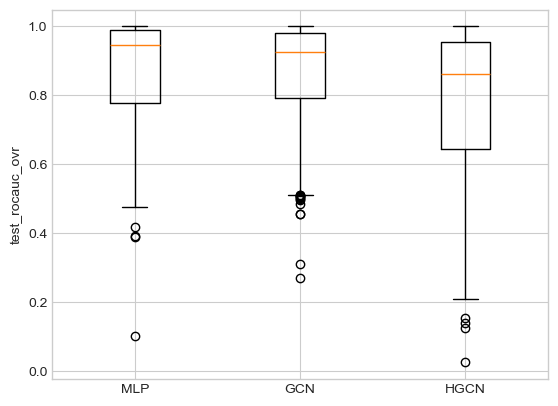

In [195]:
boxplots(df, ['MLP', 'GCN', 'HGCN'], metric = "test_rocauc_ovr")


In [79]:
# this colelction was benchmarked in a few-shot setting: one train/val per class.
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/1_train/1_train'
df = df_gen(RESULTS_DIR, NSHARDS)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


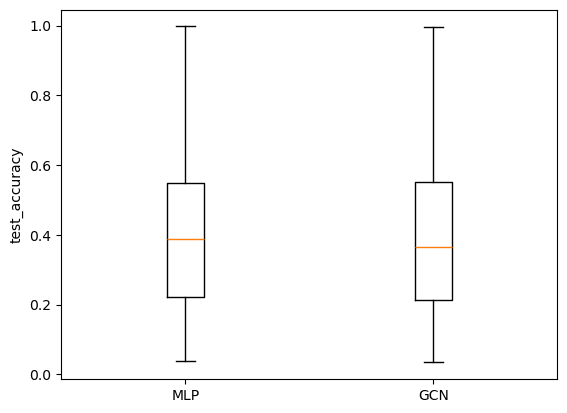

In [83]:
boxplots(df, models, "test_accuracy")

## Back to main thing

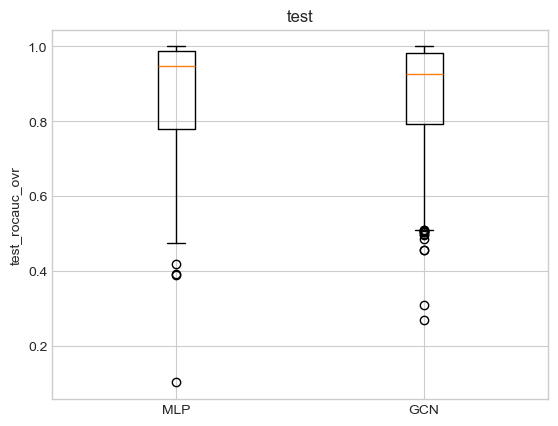

In [193]:
boxplots(df, models = ['MLP', 'GCN'], metric = 'test_rocauc_ovr', label = 'test')

In [23]:
df[['GCN__test_rocauc_ovr', 'MLP__test_rocauc_ovr']].describe()

GCN__test_rocauc_ovr  MLP__test_rocauc_ovr
count           5000.000000           5000.000000
mean               0.868397              0.874876
std                0.145639              0.146041
min                0.044087              0.062610
25%                0.789095              0.794572
50%                0.930677              0.944550
75%                0.981743              0.987504
max                1.000000              1.000000

In [42]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'approximate_diameter', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

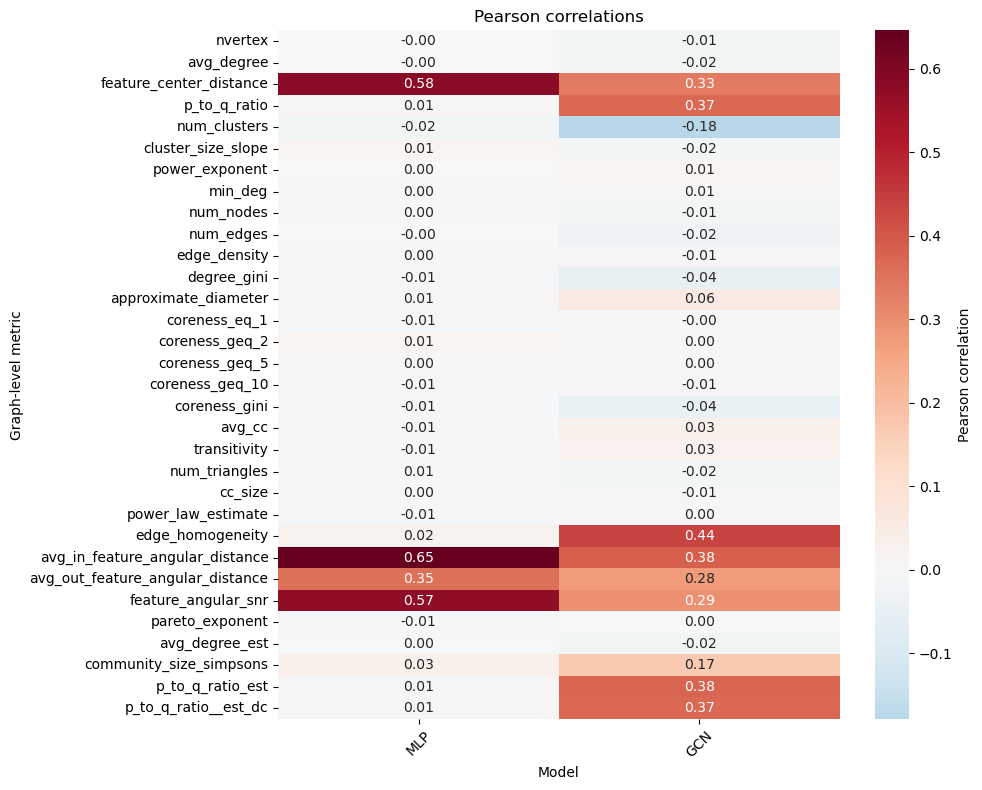

MLP       GCN
nvertex                          -0.000695 -0.014888
avg_degree                       -0.000929 -0.019917
feature_center_distance           0.583347  0.334226
p_to_q_ratio                      0.006615  0.371627
num_clusters                     -0.019753 -0.178447
cluster_size_slope                0.013734 -0.018438
power_exponent                    0.000689  0.012369
min_deg                           0.004220  0.007832
num_nodes                         0.002821 -0.014544
num_edges                        -0.004025 -0.024499
edge_density                      0.004761 -0.008714
degree_gini                      -0.008484 -0.044607
approximate_diameter              0.009433  0.055253
coreness_eq_1                    -0.011635 -0.004776
coreness_geq_2                    0.011635  0.004776
coreness_geq_5                    0.003797  0.002275
coreness_geq_10                  -0.005699 -0.009360
coreness_gini                    -0.007220 -0.042394
avg_cc                           -0.006288  0.032702
transitivity                     -0.006840  0.030561
num_triangles                     0.005017 -0.019859
cc_size                           0.002138 -0.010308
power_law_estimate               -0.005407  0.003611
edge_homogeneity                  0.024259  0.436085
avg_in_feature_angular_distance   0.646295  0.382404
avg_out_feature_angular_distance  0.354755  0.278757
feature_angular_snr               0.569069  0.293314
pareto_exponent                  -0.006374  0.000902
avg_degree_est                    0.000018 -0.018689
community_size_simpsons           0.034264  0.167616
p_to_q_ratio_est                  0.009664  0.375717
p_to_q_ratio__est_dc              0.007112  0.372282

In [43]:
compute_and_plot_graph_metric_correlations(df, graph_metrics=graph_metrics, models = models, perf_suffix='test_rocauc_ovr')

<Axes: >

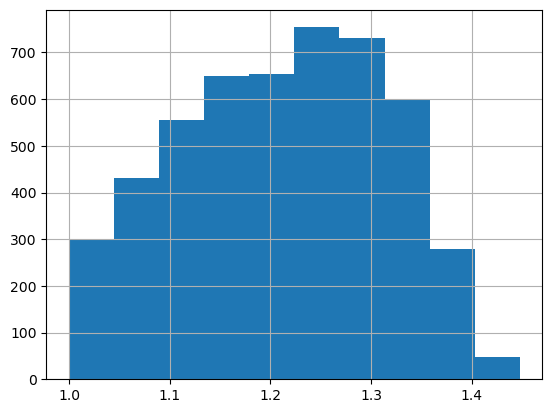

In [47]:
df['feature_angular_snr'].hist()

In [54]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


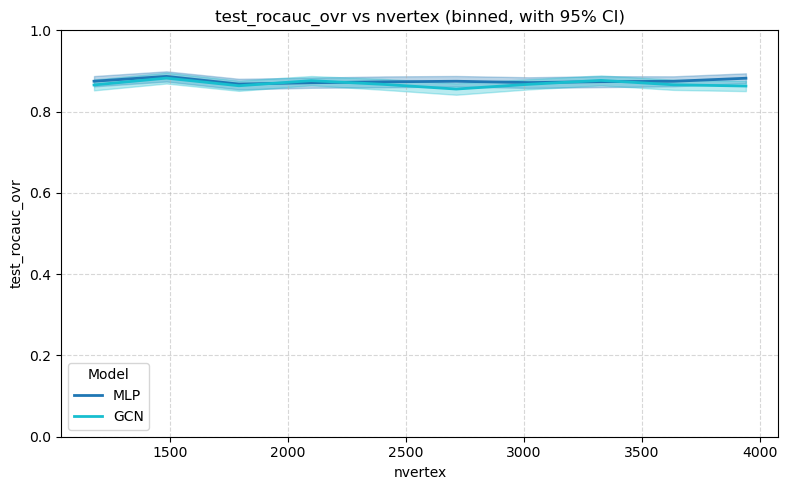

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


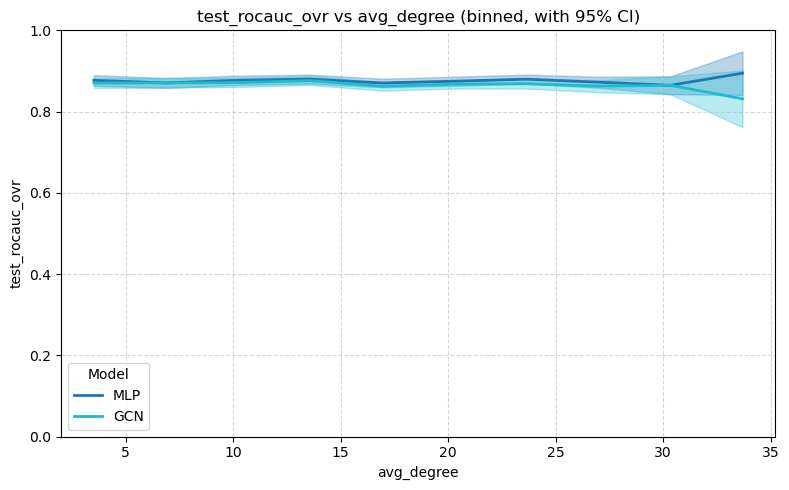

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


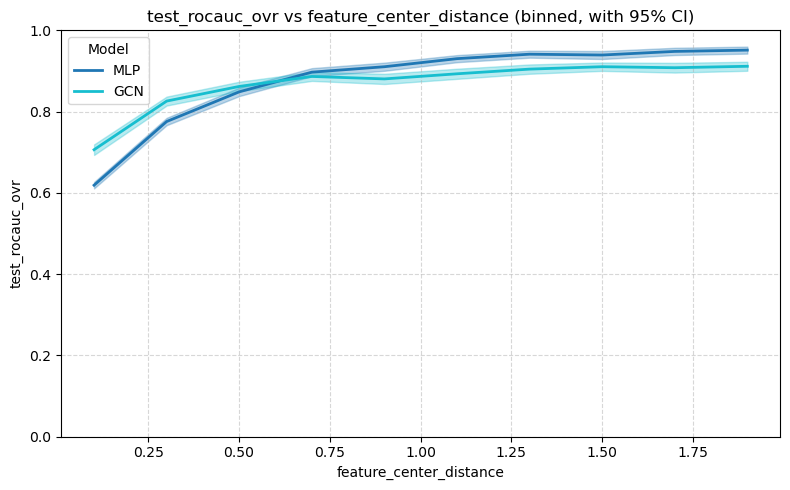

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


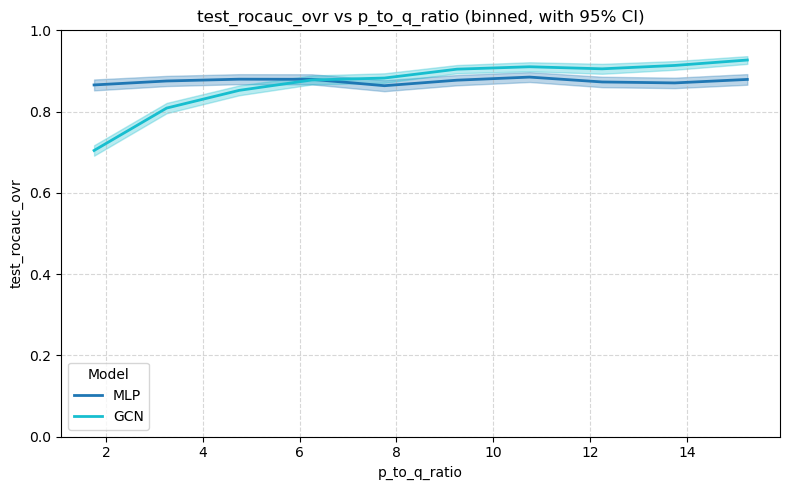

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


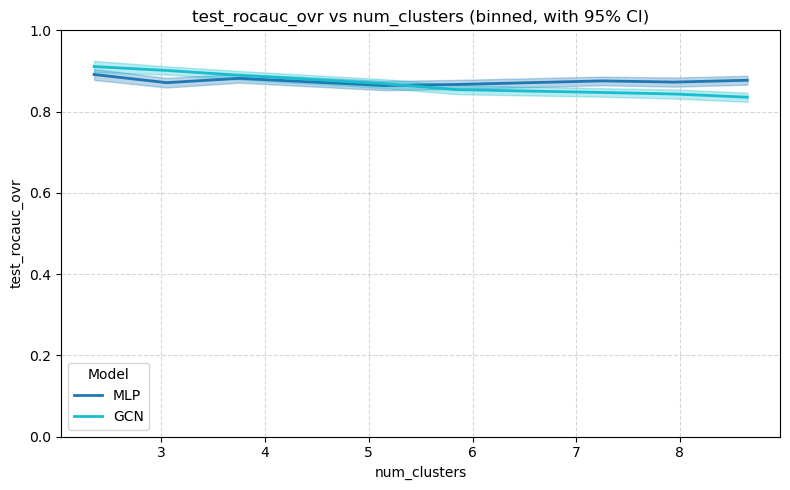

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


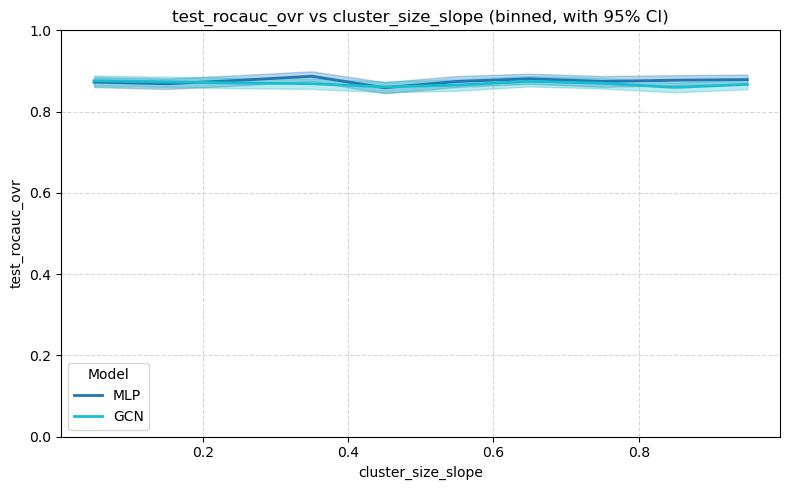

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


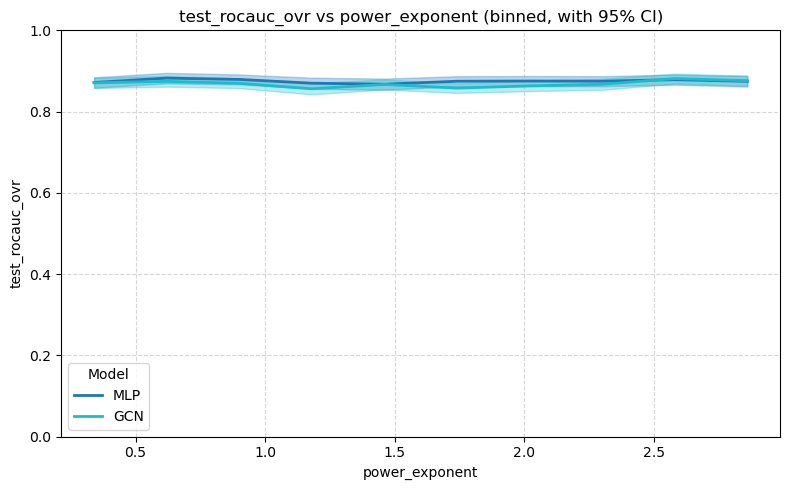

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


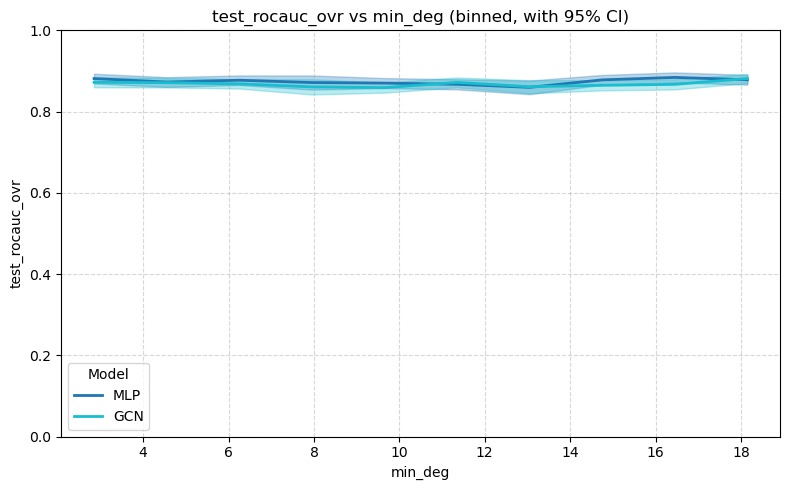

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


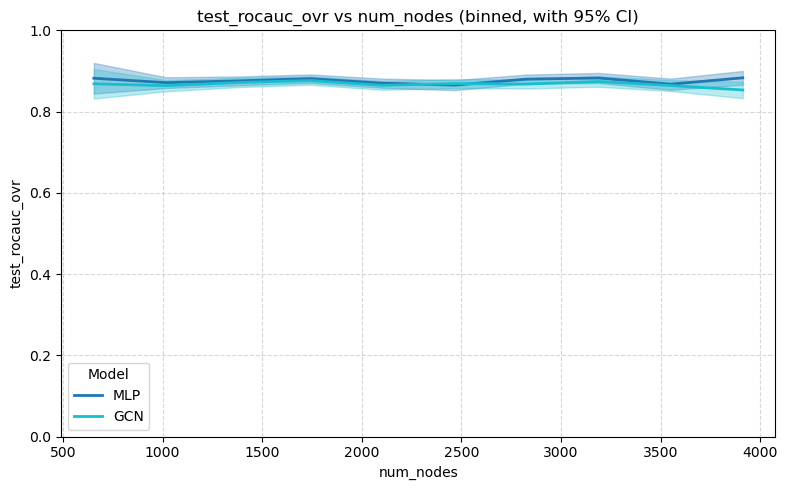

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


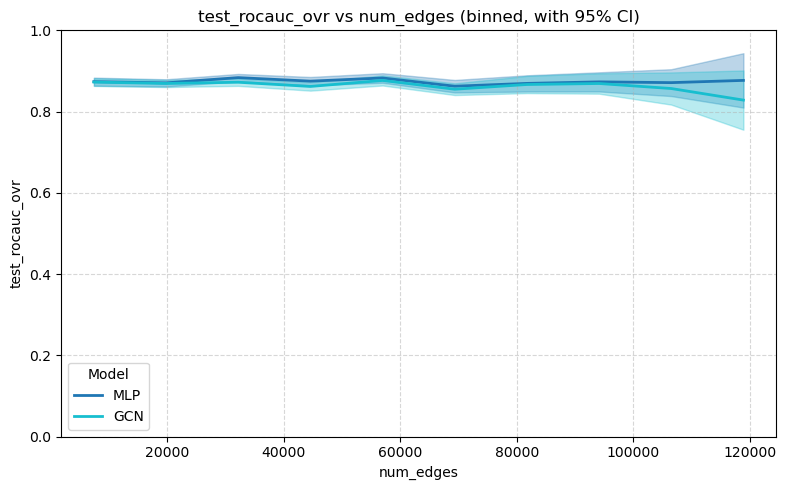

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


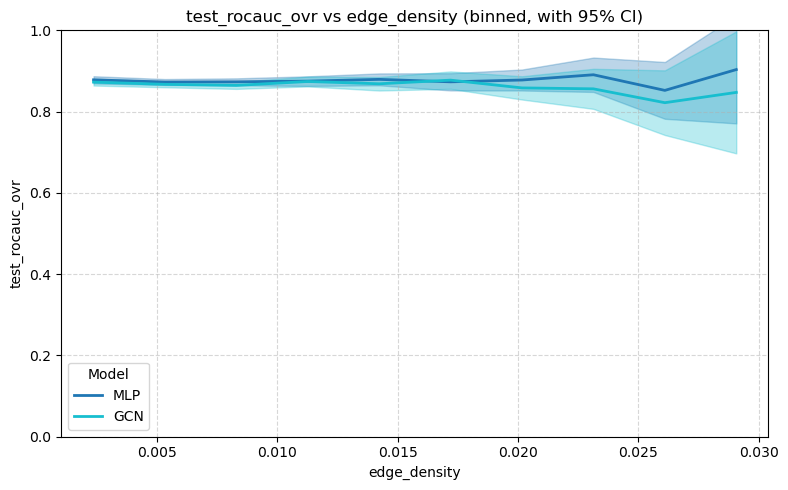

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


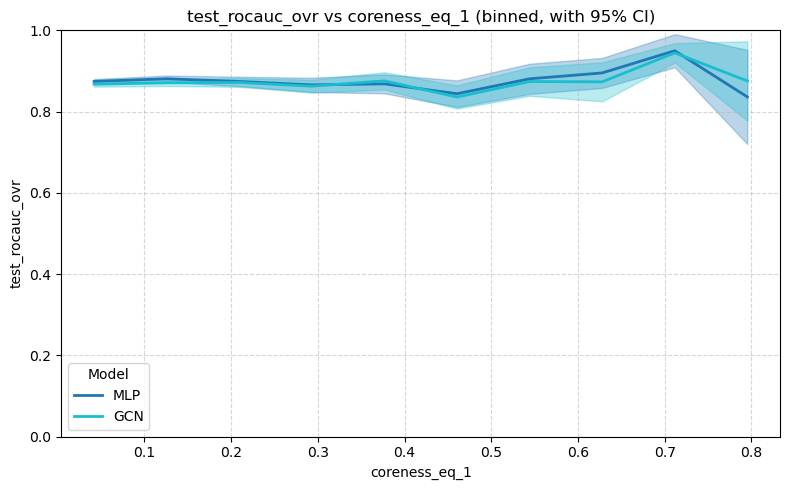

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


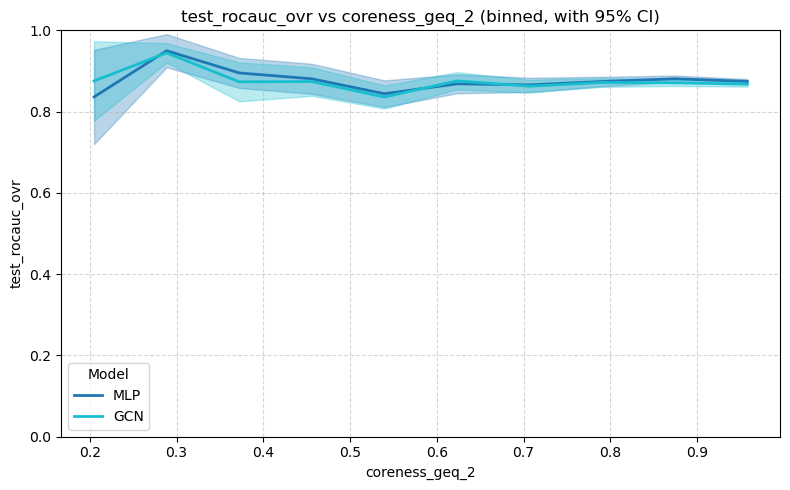

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


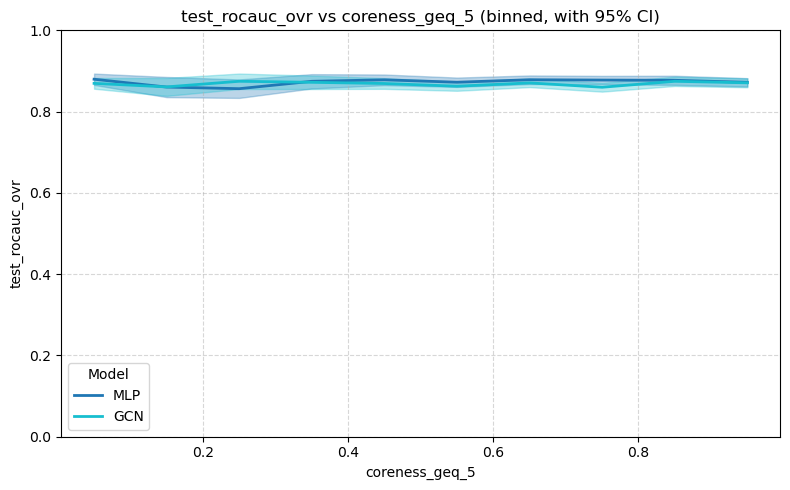

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


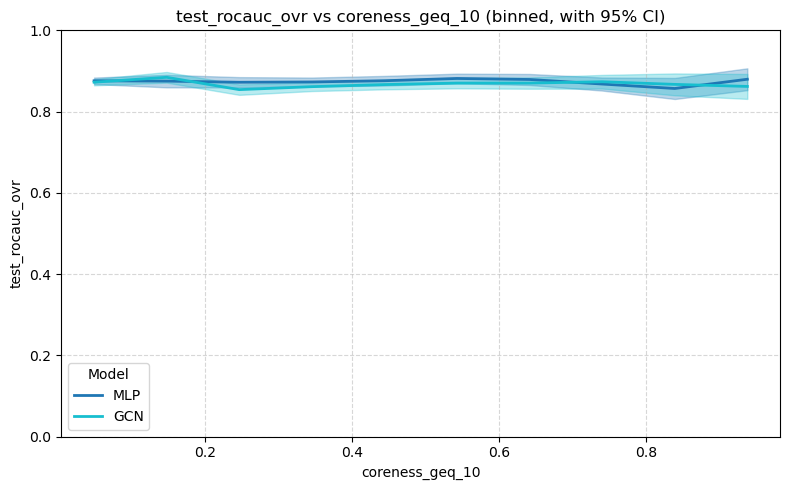

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


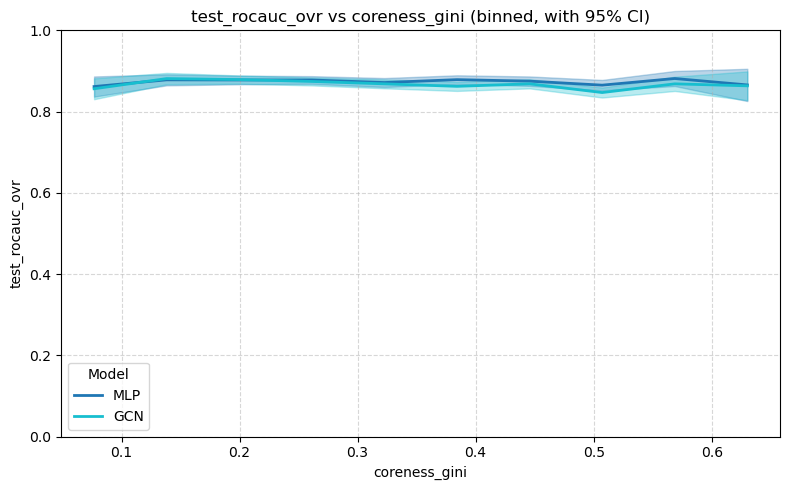

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


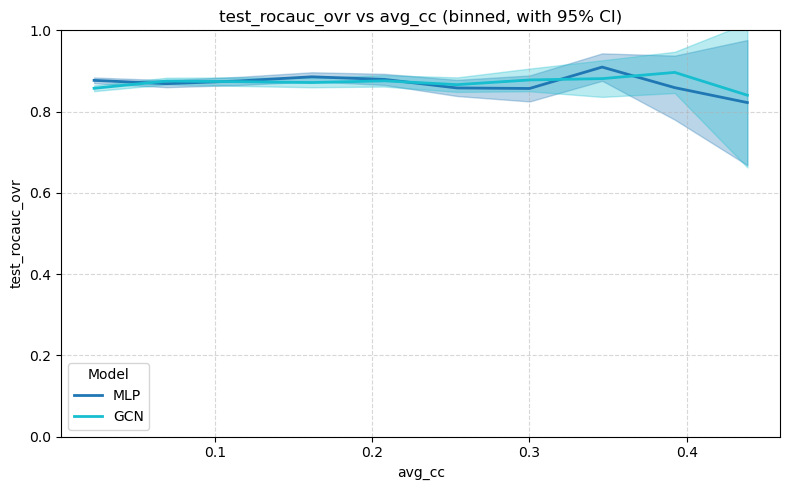

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


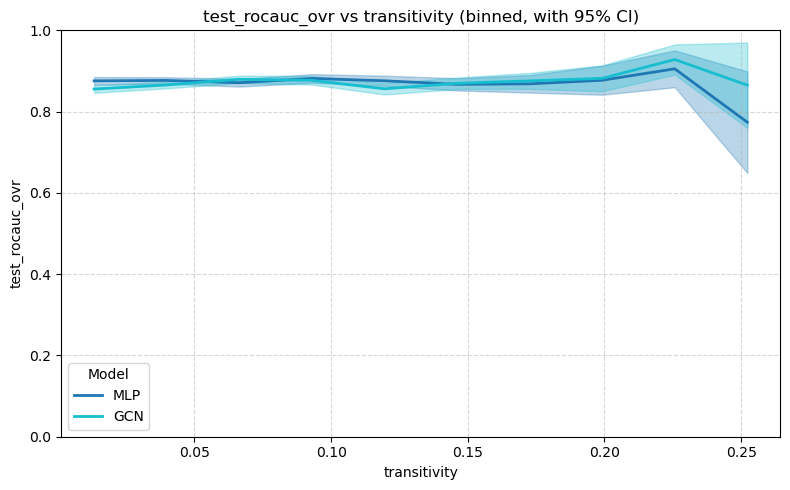

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


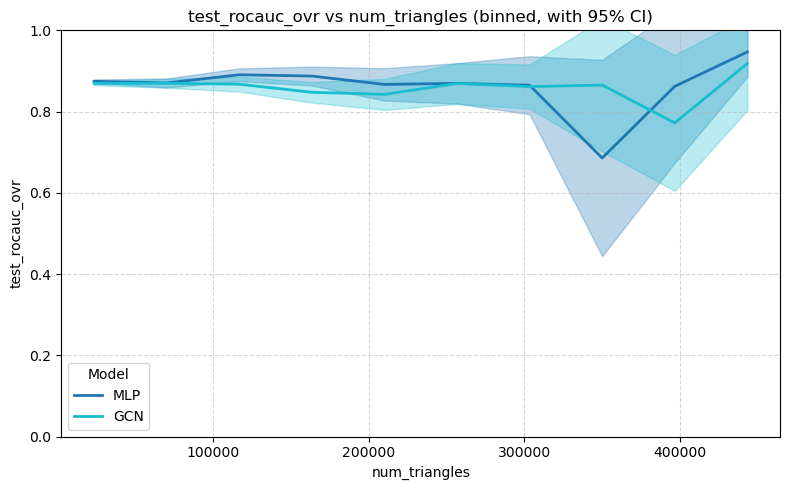

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


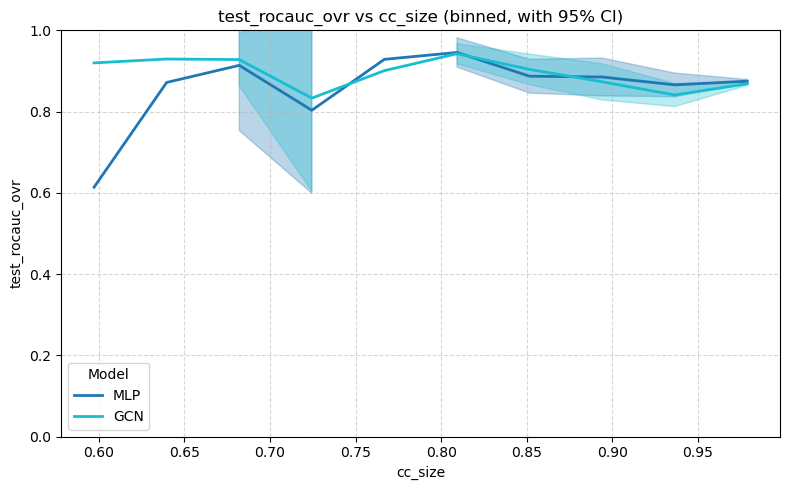

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


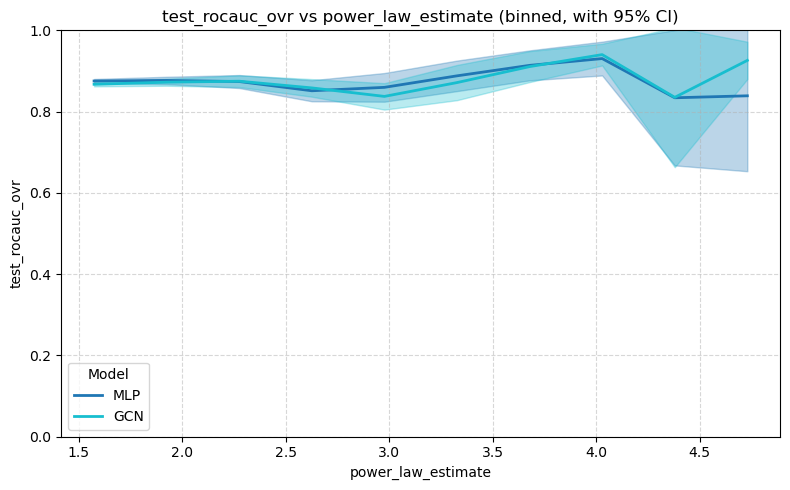

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


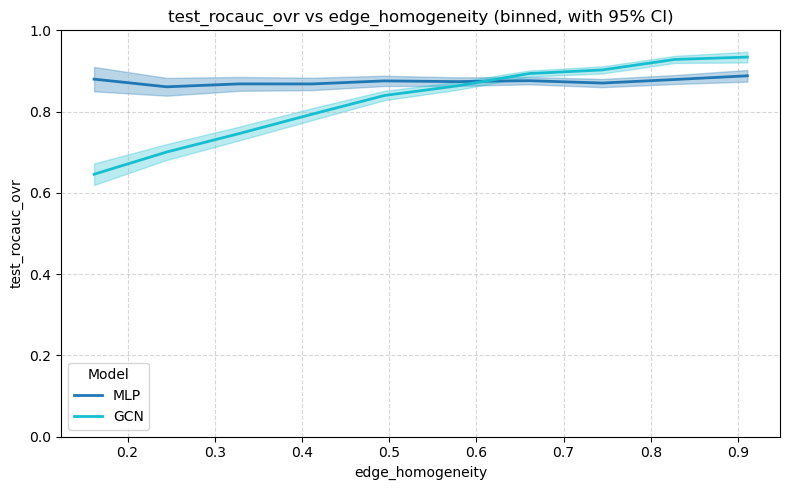

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


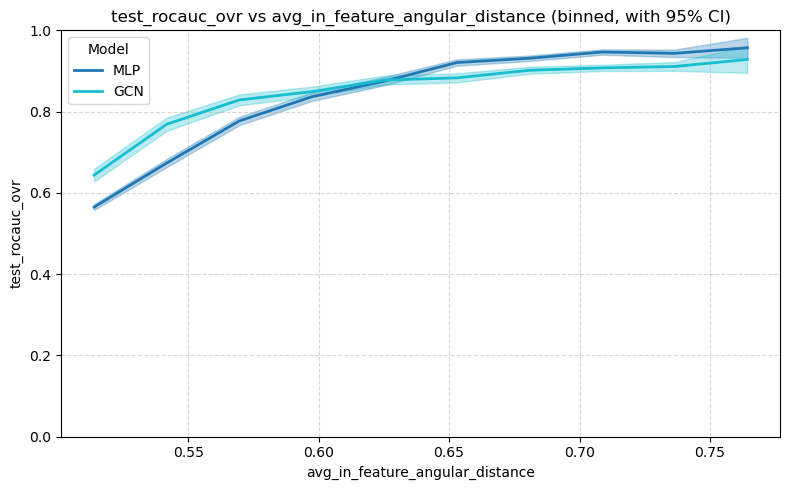

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


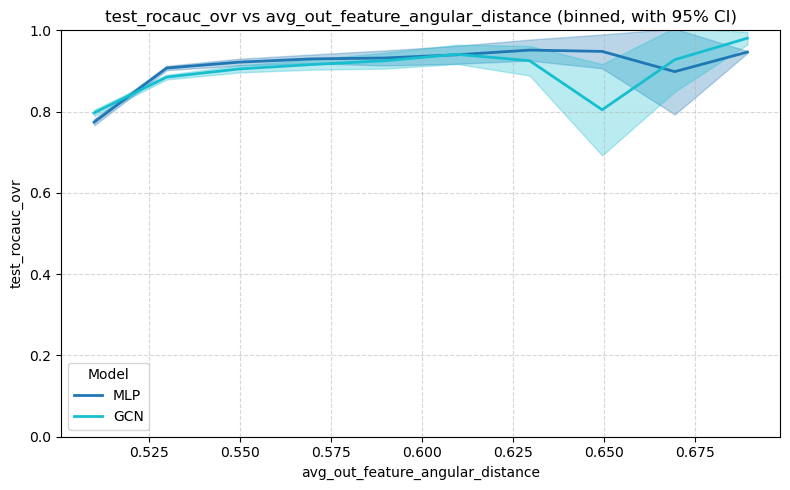

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


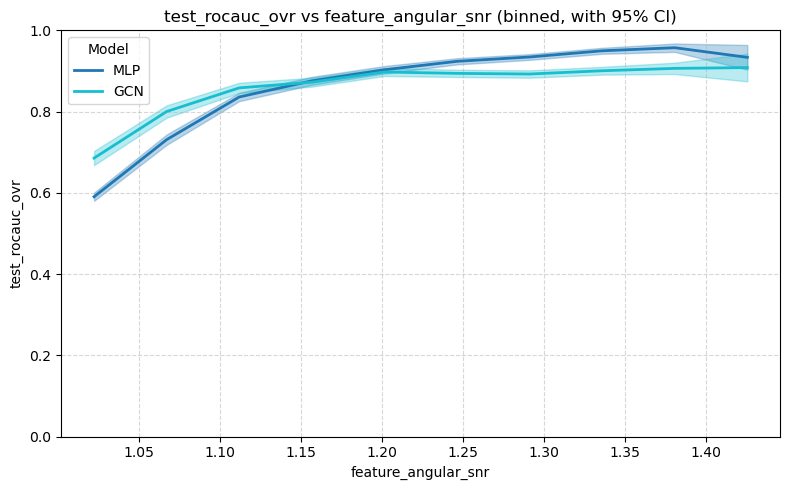

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


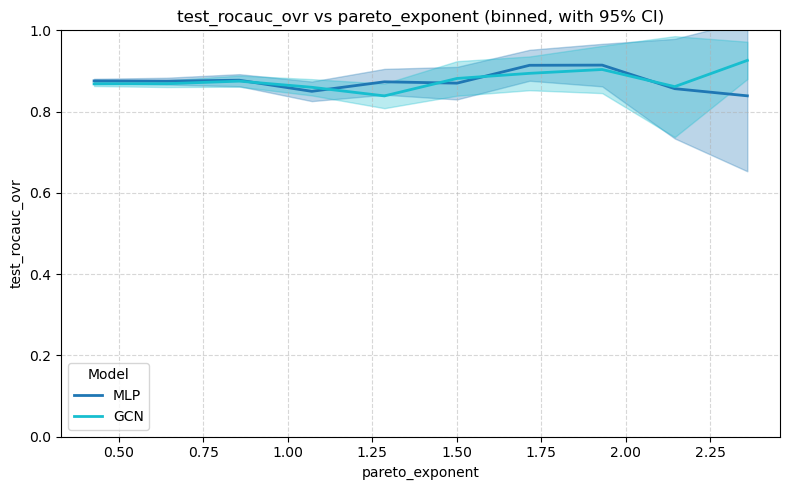

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


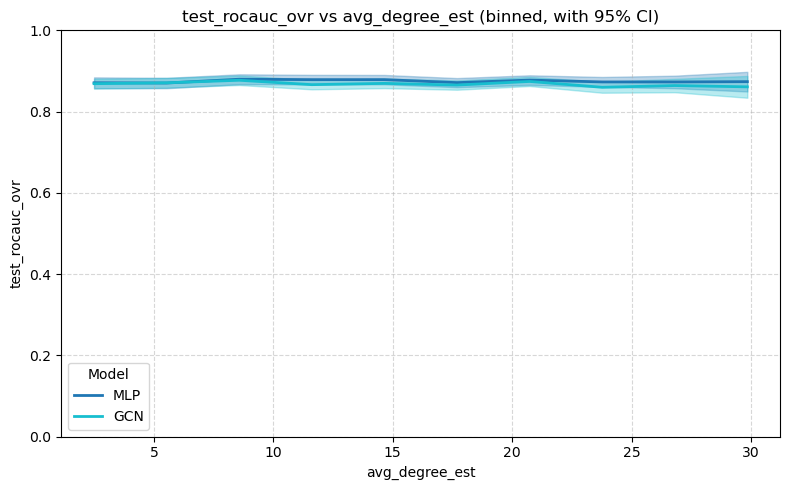

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


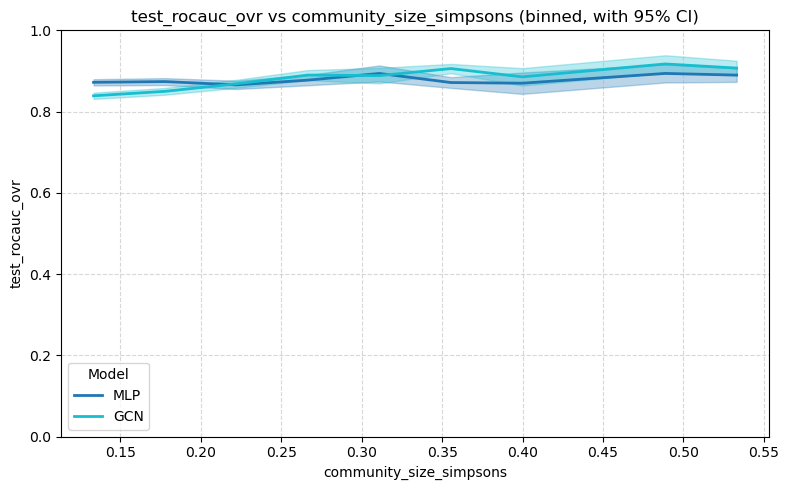

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


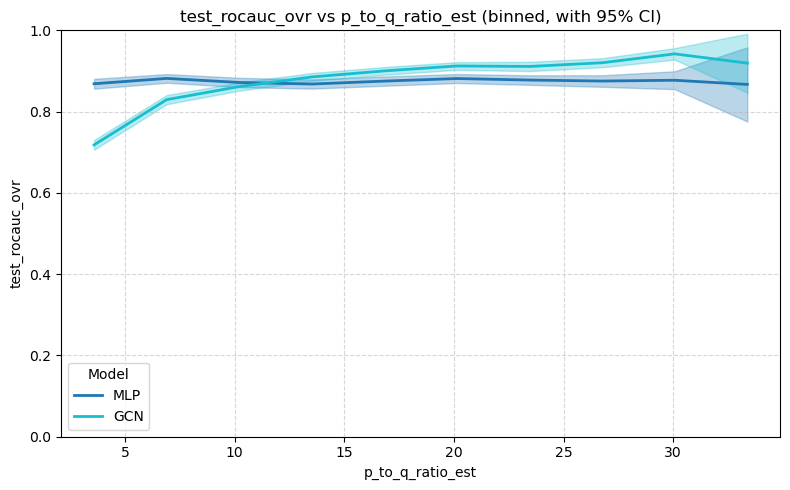

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_17391/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


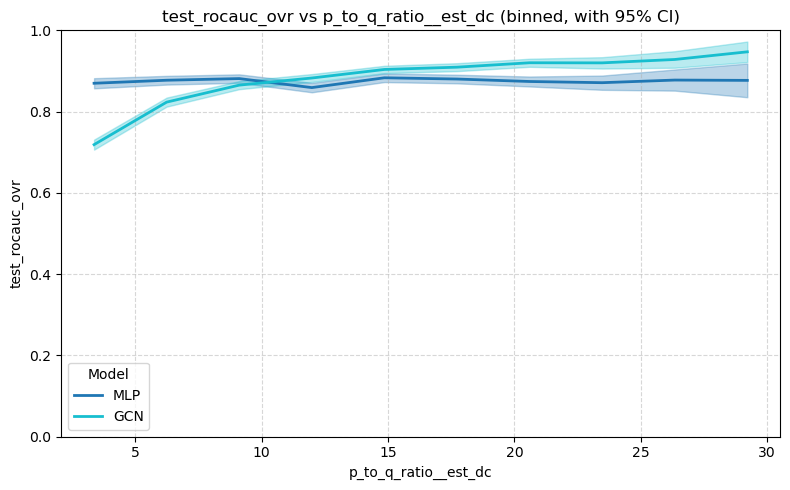

In [56]:
for metric in graph_metrics:
    smoothed_plot_perf_vs_metric(df, models, perf_meas='test_rocauc_ovr', metric=metric, n_bins=10)

In [63]:
metric = 'test_rocauc_ovr'

gcn_col = f"GCN__{metric}"
mlp_col = f"MLP__{metric}"

df['gcn_minus_mlp'] = df[gcn_col] - df[mlp_col]
df['gcn_beats_mlp'] = (df['gcn_minus_mlp'] > 0).astype(int)

print("\n==== Overall performance comparison (paired) ====\n")
t_stat, t_p = ttest_rel(df[gcn_col], df[mlp_col])
w_stat, w_p = wilcoxon(df[gcn_col], df[mlp_col])
print(f"Paired t‑test   : t={t_stat:8.3f}, p={t_p:.3g}")
print(f"Wilcoxon signed‑rank: W={w_stat:8.3f}, p={w_p:.3g}\n")


==== Overall performance comparison (paired) ====

Paired t‑test   : t=  -2.698, p=0.00699
Wilcoxon signed‑rank: W=5997442.000, p=0.0147



In [21]:
hard = df[(df['p_to_q_ratio'] < 2) & (df['feature_center_distance'] < 1.0)]

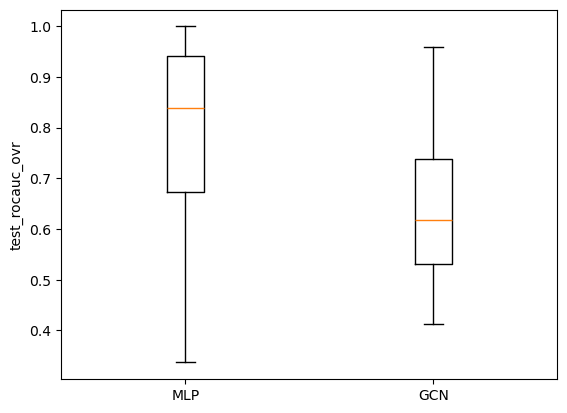

In [22]:
boxplots(hard, models, "test_rocauc_ovr")

## ablations on noise feature dim

In [137]:
# now unnormalized gaussian noise
RESULTS_DIR16 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm'
RESULTS_DIR2 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/noise_dim/noise_dim/2'
RESULTS_DIR4 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/noise_dim/noise_dim/4'
RESULTS_DIR0 = '../../graph_gen/snellius_gen/sample_gen/sample_gen'
RESULTS_DIR8 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/noise_dim/8/8'
df16 = df_gen(RESULTS_DIR16, NSHARDS)
df2 = df_gen(RESULTS_DIR2, NSHARDS)
df4 = df_gen(RESULTS_DIR4, NSHARDS)
df0 = df_gen(RESULTS_DIR0, NSHARDS)
df8 = df_gen(RESULTS_DIR8, NSHARDS)


results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

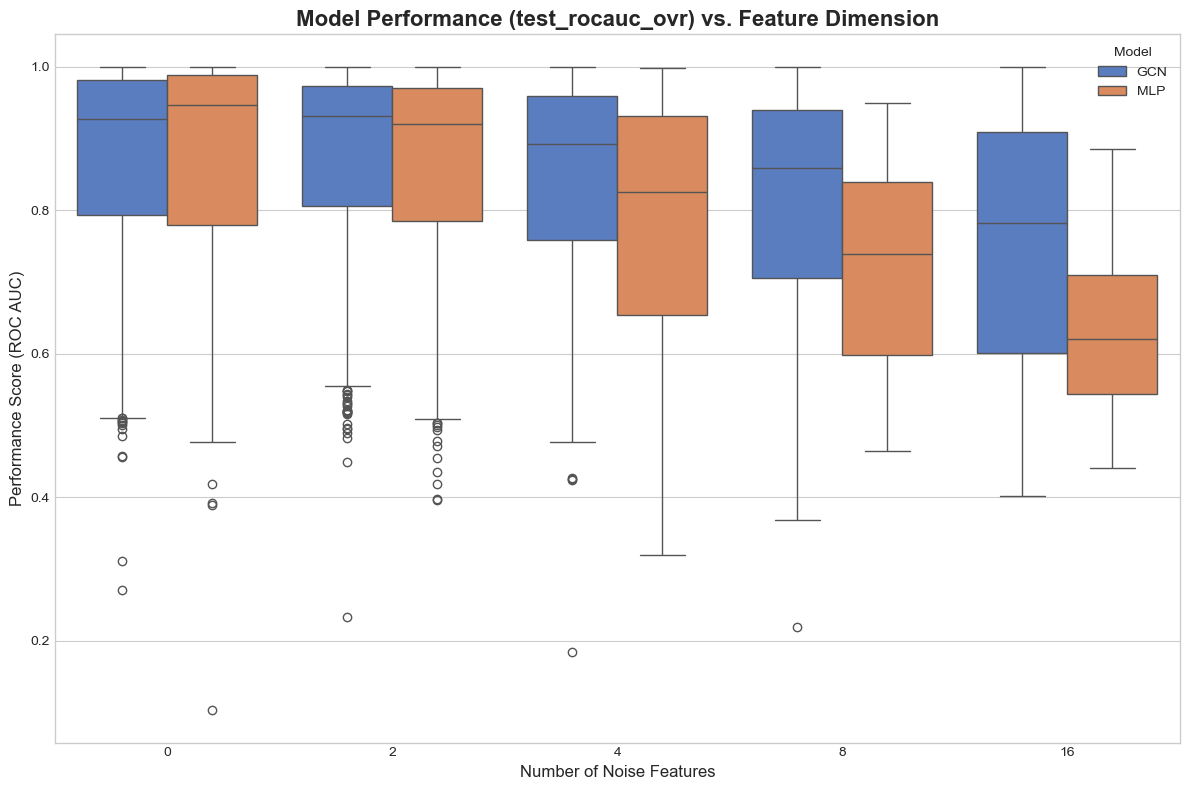

In [143]:

models = ['GCN', 'MLP']
metric = 'test_rocauc_ovr'
noise_feature_dims = [0, 2, 4, 8, 16]
dfs = [df0, df2, df4, df8, df16]

plot_data = []
for i, df in enumerate(dfs):
    # Select the metric columns for the models
    df_copy = df[[f'{model}__{metric}' for model in models]].copy()
    # Add the feature dimension column
    df_copy['feature_dim'] = noise_feature_dims[i]
    plot_data.append(df_copy)

combined_df_wide = pd.concat(plot_data, ignore_index=True)


# --- 3. Reshape Data from Wide to Long Format ---
# This is the key step. We use `pd.melt` to turn the model columns
# into rows, making the data suitable for seaborn's `hue` parameter.

id_vars = ['feature_dim']
value_vars = [f'{model}__{metric}' for model in models]

combined_df_long = pd.melt(
    combined_df_wide,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='model_metric', # New column for the original column names
    value_name='performance_score' # New column for the performance values
)

# Clean up the model names (e.g., 'GCN__test_rocauc_ovr' -> 'GCN')
combined_df_long['model'] = combined_df_long['model_metric'].str.replace(f'__{metric}', '', regex=False)


# --- 4. Create the Combined Boxplot ---
# Now we create a single plot, using `hue` to differentiate the models.

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.boxplot(
    x='feature_dim',
    y='performance_score',
    hue='model', # This tells seaborn to use different colors for each model
    data=combined_df_long,
    ax=ax,
    palette='muted' # A nice color palette
)

# --- 5. Customize and Show the Plot ---
ax.set_title(f'Model Performance ({metric}) vs. Feature Dimension', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Noise Features', fontsize=12)
ax.set_ylabel('Performance Score (ROC AUC)', fontsize=12)
ax.legend(title='Model') # Add a legend to identify the colors

plt.tight_layout()
plt.show()


In [153]:
for i, df in enumerate(dfs):
    print(f"Number of graph samples for noise dimension {noise_feature_dims[i]}", df.shape[0])

Number of graph samples for noise dimension 0 1000
Number of graph samples for noise dimension 2 500
Number of graph samples for noise dimension 4 500
Number of graph samples for noise dimension 8 250
Number of graph samples for noise dimension 16 500


## New dataset - 5000 samples, signal+noise features

In [246]:
NSHARDS = 10
models = ['MLP', 'GCN']
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm'
RESULTS_DIR1 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/1'
RESULTS_DIR2 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/2'
RESULTS_DIR3 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/3'
RESULTS_DIR4 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/4'
RESULTS_DIR5 = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/test_noise_no_norm/5'

df = df_gen(RESULTS_DIR, NSHARDS)
df1 = df_gen(RESULTS_DIR1, NSHARDS)
df2 = df_gen(RESULTS_DIR2, NSHARDS)
df3 = df_gen(RESULTS_DIR3, NSHARDS)
df4 = df_gen(RESULTS_DIR4, NSHARDS)
df5 = df_gen(RESULTS_DIR5, NSHARDS)


df = pd.concat([df, df1, df2, df3, df4, df5], axis = 0)
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

nvertex  avg_degree  feature_center_distance  feature_dim  \
0        1352    9.562289                 0.390386           16   
1        1359   13.115789                 1.715084           16   
2        3530    4.380339                 0.683335           16   
3        3551   18.522669                 0.491903           16   
4        2919   16.854589                 0.967202           16   
...       ...         ...                      ...          ...   
4995     3609    8.031199                 0.284539           16   
4996     1056   13.282520                 0.176616           16   
4997     3578    7.994299                 1.955615           16   
4998     1191   13.736746                 0.603972           16   
4999     2778   22.349312                 0.363403           16   

      edge_center_distance  edge_feature_dim  p_to_q_ratio  num_clusters  \
0                      1.0                 1     13.464975             7   
1                      1.0                 1     14.082951             7   
2                      1.0                 1     12.749049             8   
3                      1.0                 1      4.927547             7   
4                      1.0                 1     14.667087             7   
...                    ...               ...           ...           ...   
4995                   1.0                 1      6.456280             2   
4996                   1.0                 1      2.358084             7   
4997                   1.0                 1      9.699010             8   
4998                   1.0                 1     14.052332             9   
4999                   1.0                 1      9.282229             4   

      cluster_size_slope  power_exponent  ...  MLP__test_logloss  \
0               0.588315        0.607698  ...           1.915104   
1               0.333200        1.771090  ...           1.759299   
2               0.792320        1.960316  ...           2.054621   
3               0.447886        2.618927  ...           1.900633   
4               0.185181        2.227018  ...           1.795015   
...                  ...             ...  ...                ...   
4995            0.305609        0.407720  ...           0.690681   
4996            0.430003        0.751247  ...           1.932516   
4997            0.229193        0.995935  ...           2.082255   
4998            0.507515        0.841346  ...           2.150609   
4999            0.257014        0.224705  ...           1.370431   

      MLP__model_dropout  MLP__model_hidden_channels MLP__model_in_channels  \
0                    0.6                          16                     32   
1                    0.4                          32                     32   
2                    0.4                          16                     32   
3                    0.6                          32                     32   
4                    0.4                          16                     32   
...                  ...                         ...                    ...   
4995                 0.4                          16                     32   
4996                 0.2                           8                     32   
4997                 0.6                          16                     32   
4998                 0.6                          32                     32   
4999                 0.4                          32                     32   

      MLP__model_lr MLP__model_num_layers  MLP__model_weight_decay  \
0            0.0010                     1                   0.0001   
1            0.0020                     2                   0.0005   
2            0.0020                     1                   0.0001   
3            0.0005                     1                   0.0000   
4            0.0010                     1                   0.0010   
...             ...                   ...                      ...   
4995         0.0020             

In [173]:
hgcn_df = df_gen(RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/hgcn/hgcn', NSHARDS= NSHARDS)
hgcn_df = hgcn_df.reset_index(drop=True)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


<Axes: >

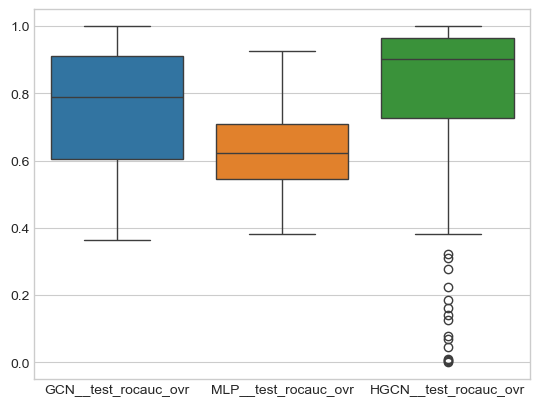

In [180]:
sns.boxplot(pd.concat([df[['GCN__test_rocauc_ovr', 'MLP__test_rocauc_ovr']], hgcn_df['HGCN__test_rocauc_ovr']]))

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/3567166480.py:84: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/daniel/miniconda3/envs/graphworld/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


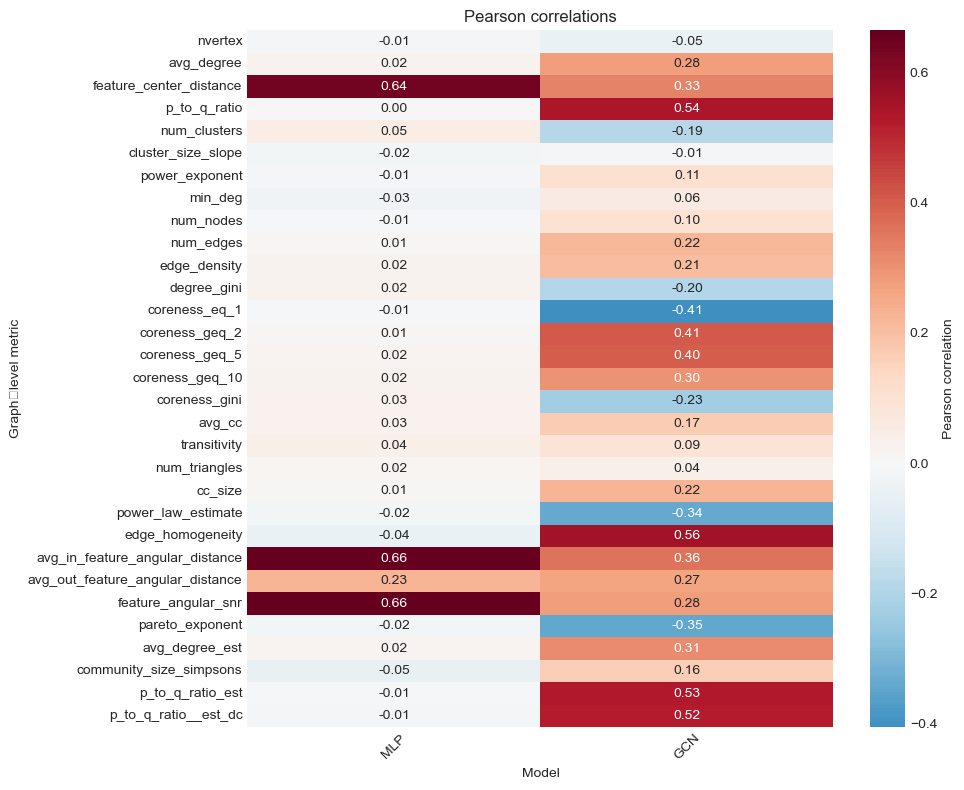

MLP       GCN
nvertex                          -0.010831 -0.045667
avg_degree                        0.023543  0.276147
feature_center_distance           0.639768  0.328603
p_to_q_ratio                      0.000507  0.541023
num_clusters                      0.047858 -0.191718
cluster_size_slope               -0.017199 -0.014026
power_exponent                   -0.010666  0.105122
min_deg                          -0.028730  0.058090
num_nodes                        -0.008336  0.102658
num_edges                         0.011789  0.219486
edge_density                      0.024589  0.206223
degree_gini                       0.022939 -0.196170
coreness_eq_1                    -0.007078 -0.405130
coreness_geq_2                    0.007078  0.405130
coreness_geq_5                    0.017154  0.402998
coreness_geq_10                   0.022310  0.296883
coreness_gini                     0.026085 -0.227018
avg_cc                            0.033286  0.168808
transitivity                      0.039179  0.090042
num_triangles                     0.015480  0.038862
cc_size                           0.012448  0.222376
power_law_estimate               -0.018233 -0.340468
edge_homogeneity                 -0.042069  0.555653
avg_in_feature_angular_distance   0.664059  0.359028
avg_out_feature_angular_distance  0.227403  0.266976
feature_angular_snr               0.662164  0.276995
pareto_exponent                  -0.016847 -0.345847
avg_degree_est                    0.020254  0.312773
community_size_simpsons          -0.048217  0.163400
p_to_q_ratio_est                 -0.007042  0.528951
p_to_q_ratio__est_dc             -0.008367  0.521840

In [244]:
perf_meas = "test_rocauc_ovr"
df['perf_delta'] = df[f'GCN__{perf_meas}']-df[f'MLP__{perf_meas}']

graph_metrics_refined = ['nvertex', 'avg_degree', 'degree_gini', 'edge_homogeneity',
                 'num_clusters', 'community_size_simpsons', 'feature_angular_snr',
                 'avg_cc']

graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

compute_and_plot_graph_metric_correlations(df, graph_metrics=graph_metrics, models=models, perf_suffix=perf_meas)

<Axes: >

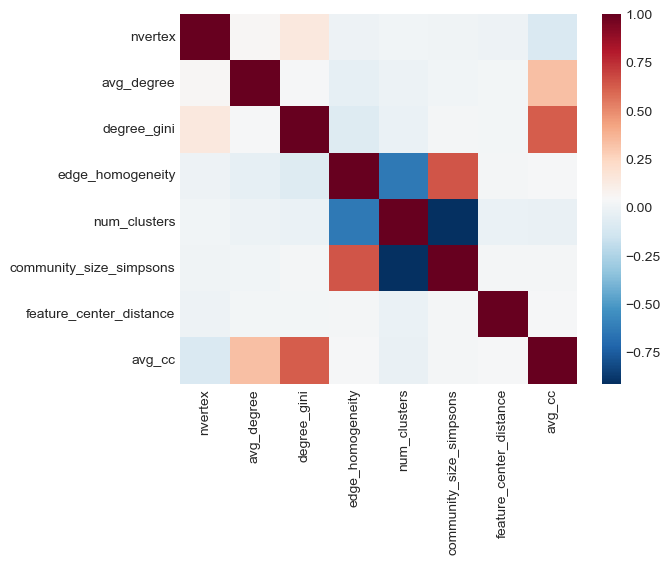

In [240]:
sns.heatmap(df[graph_metrics_refined].corr(),
                cmap = 'RdBu_r',
                xticklabels=True,
                yticklabels=True)

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


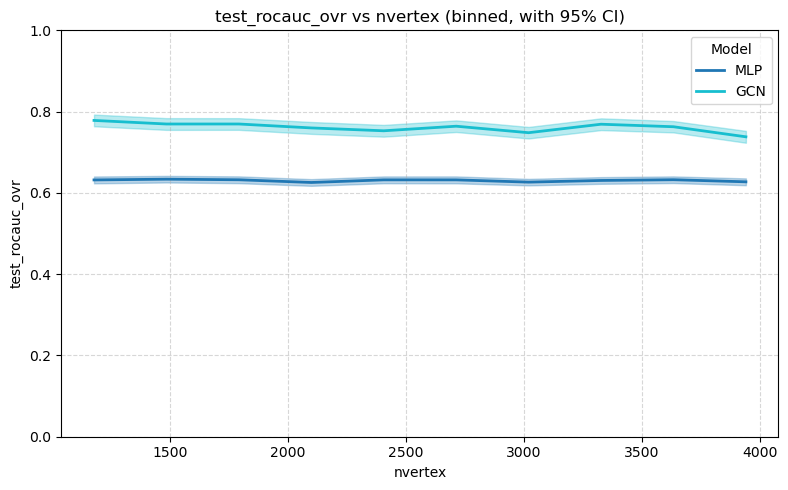

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


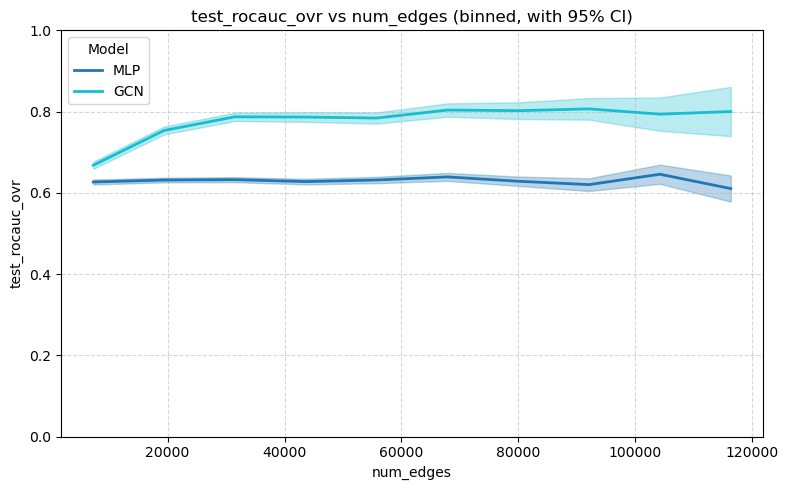

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


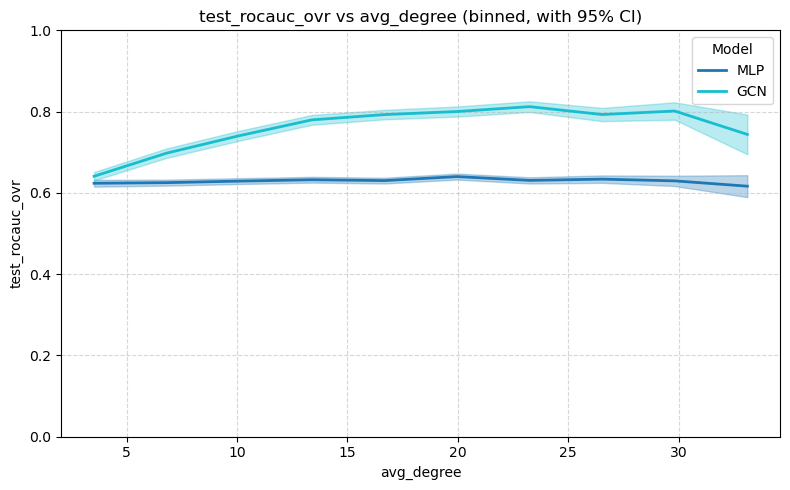

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


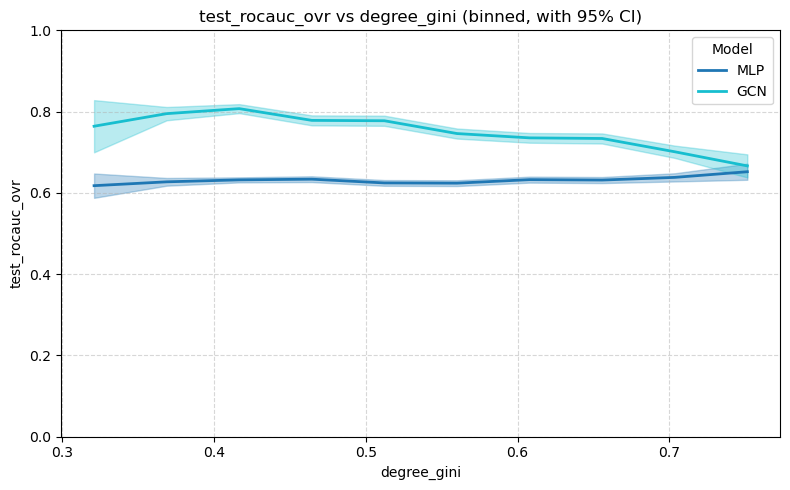

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


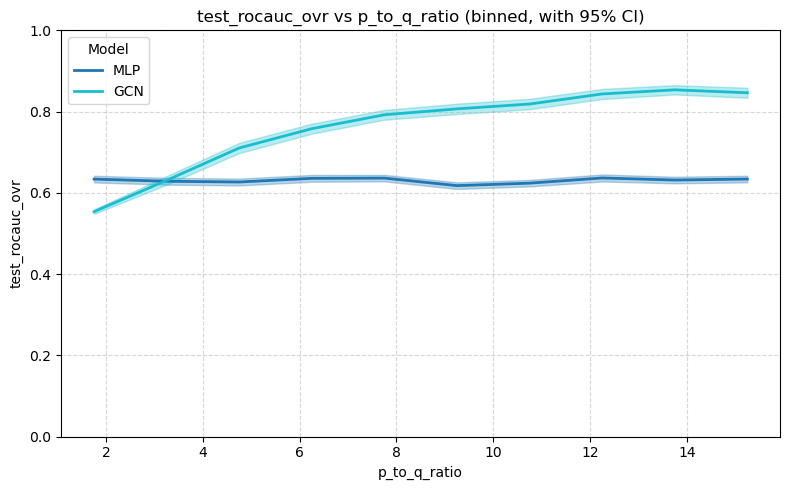

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


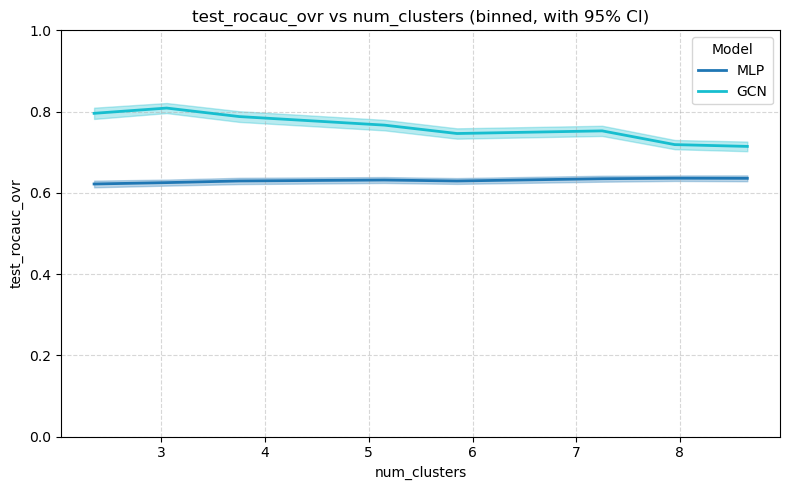

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


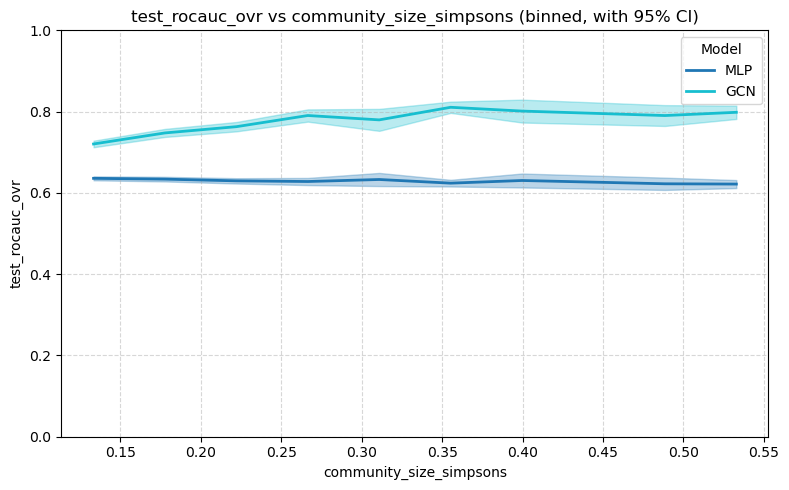

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


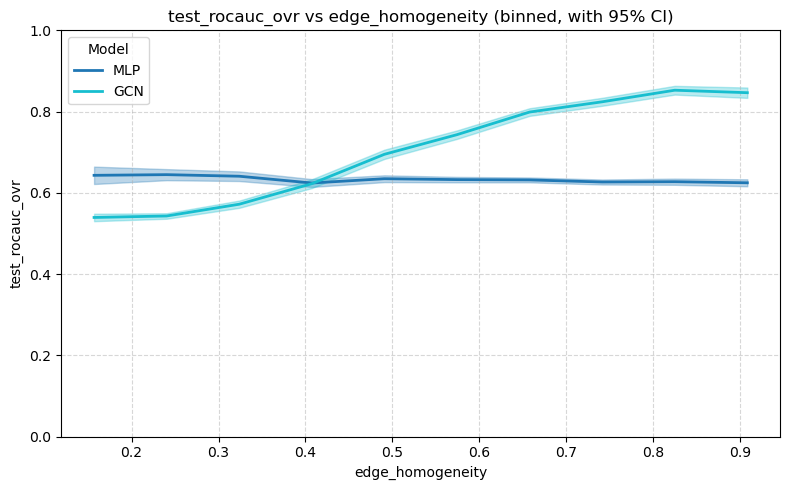

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


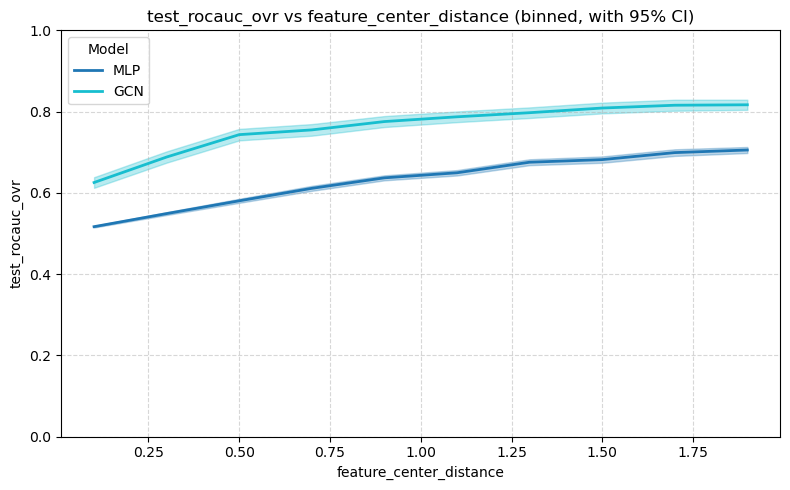

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


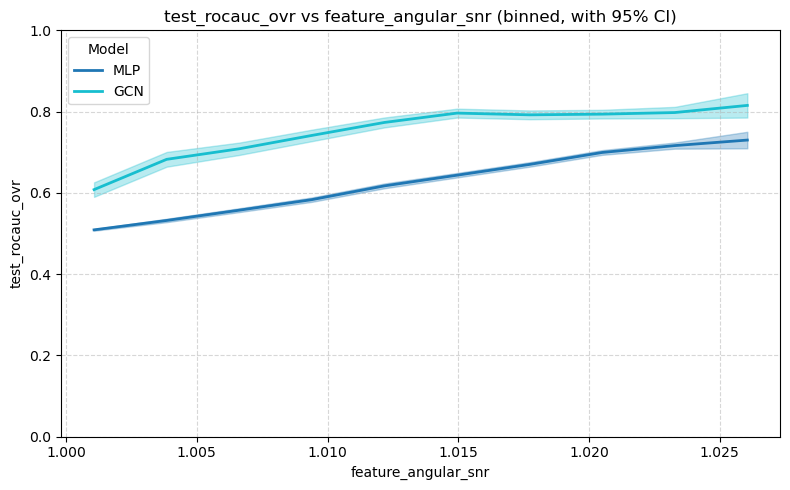

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


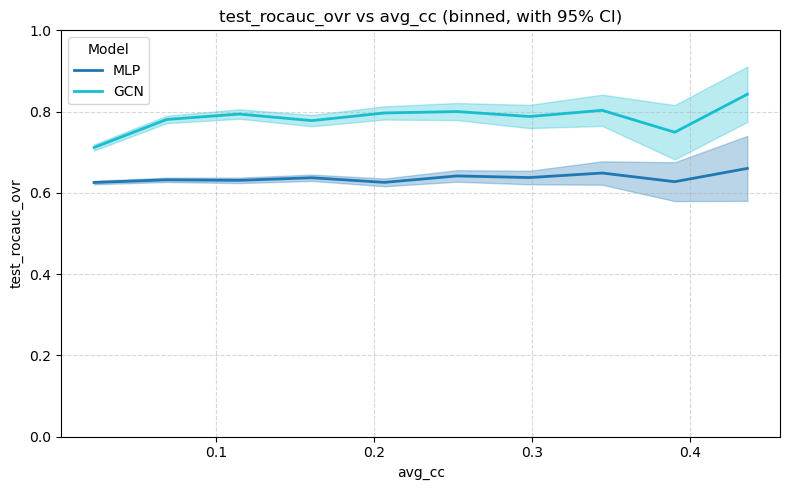

In [86]:
for m in graph_metrics_refined:
    smoothed_plot_perf_vs_metric(df, models, perf_meas, m)

Using XGBoost version: 3.0.2

Training XGBoost model...
Model training complete.

--- Model Evaluation ---
Root Mean Squared Error (RMSE): 0.1149
R-squared (R²): 0.5289
------------------------

Interpretation:
RMSE: On average, the model's prediction for 'Perf_Delta' is off by ~0.11 performance points.
R²: The model explains ~52.9% of the variance in the GCN-MLP performance gap.

--- Feature Importance ---
                   Feature  Importance
3         edge_homogeneity    0.350962
1               avg_degree    0.126349
2              degree_gini    0.111780
7                   avg_cc    0.106779
6      feature_angular_snr    0.087299
5  community_size_simpsons    0.084662
4             num_clusters    0.083042
0                  nvertex    0.049127
--------------------------


/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/1230853759.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


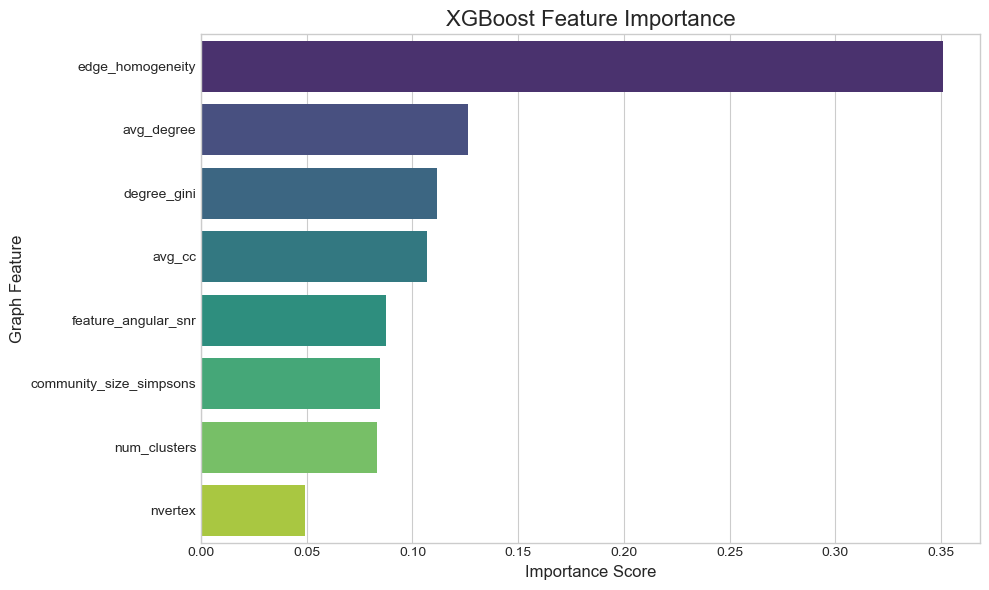

In [245]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print(f"Using XGBoost version: {xgb.__version__}")


# Create or load the data
data = df
predictor_features = graph_metrics_refined

X = data[predictor_features]

if 'perf_data' in data.columns:
    y = data['perf_delta'] 
else:
    data['perf_delta'] = data['GCN__test_rocauc_ovr']-data['MLP__test_rocauc_ovr']
    y = data['perf_delta']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgbr = xgb.XGBRegressor(
    objective='reg:squarederror', # Objective function for regression
    n_estimators=1000,            # Number of trees to build.
    max_depth=5,                  # Maximum depth of a tree. Deeper trees can model more complex relationships but can also overfit.
    learning_rate=0.05,           # Step size shrinkage to prevent overfitting.
    subsample=0.8,                # Fraction of samples to be used for fitting each tree.
    colsample_bytree=0.8,         # Fraction of features to be used for fitting each tree.
    random_state=42,              # Seed for reproducibility
    n_jobs=-1                     # Use all available CPU cores
)

print("\nTraining XGBoost model...")

xgbr.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Set to True if you want to see training progress
)

print("Model training complete.")


# --- Step 4: Evaluate the Model on the Test Set ---

# Make predictions on the unseen test data
y_pred = xgbr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("------------------------")
print("\nInterpretation:")
print(f"RMSE: On average, the model's prediction for 'Perf_Delta' is off by ~{rmse:.2f} performance points.")
print(f"R²: The model explains ~{r2*100:.1f}% of the variance in the GCN-MLP performance gap.")


# --- Step 5: Analyze Feature Importance ---

# This is the key part for answering your research question.
# Which features did the model find most predictive?

# Get feature importance from the trained model
importances = xgbr.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance ---")
print(importance_df)
print("--------------------------")

# Plotting the feature importances
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Graph Feature', fontsize=12)
plt.tight_layout()
plt.show()

In [218]:
## comparing HGCN MLP & GCN perf
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/all_model_comp/all_model_comp'
df = df_gen(RESULTS_DIR, NSHARDS) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


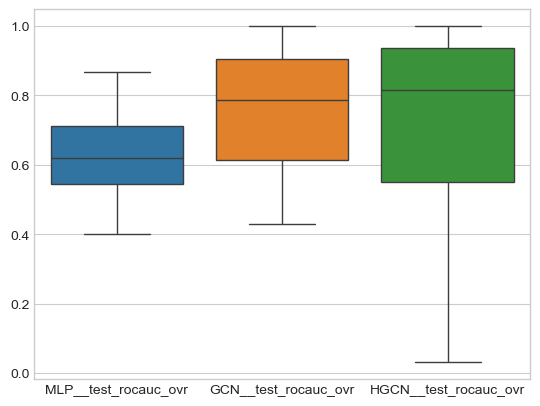

In [226]:
models = ['MLP', 'GCN', 'HGCN']
metric = 'test_rocauc_ovr'

sns.boxplot(df[[f'{model}__{metric}' for model in models]])
plt.show()

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

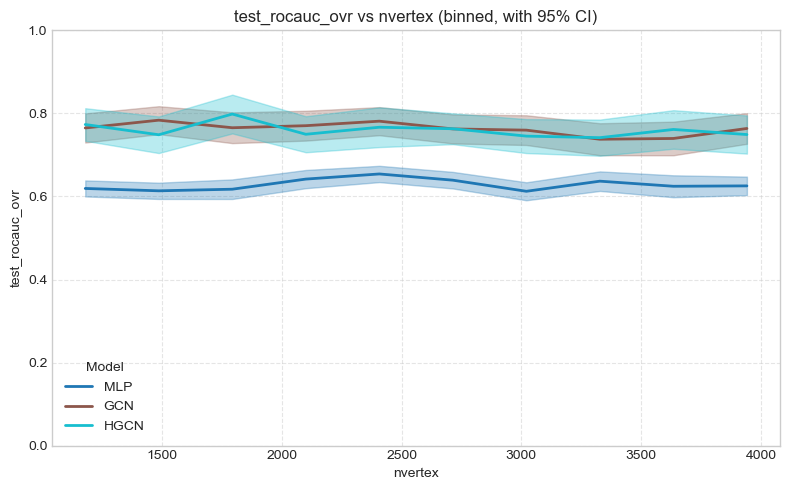

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

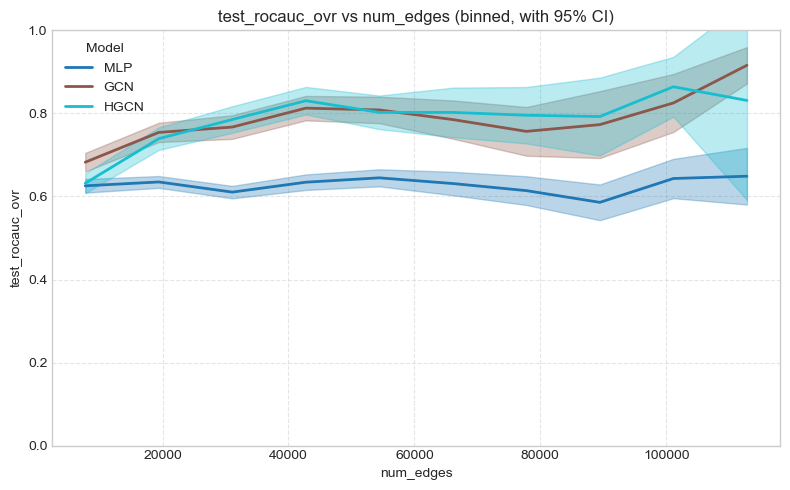

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

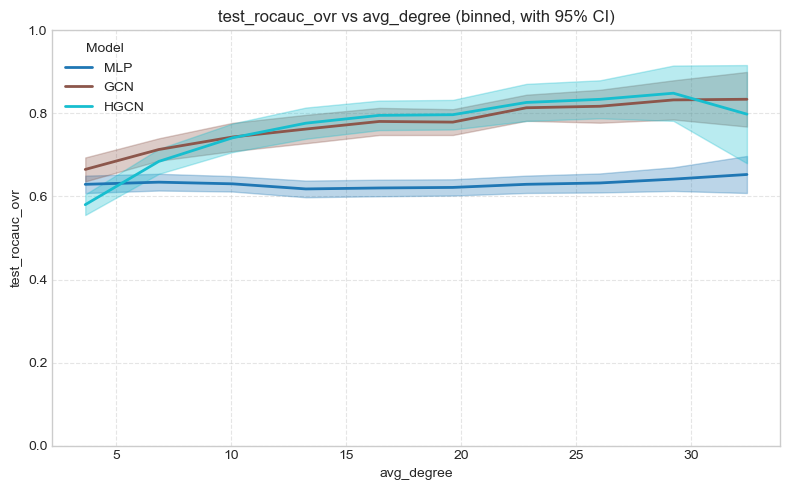

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

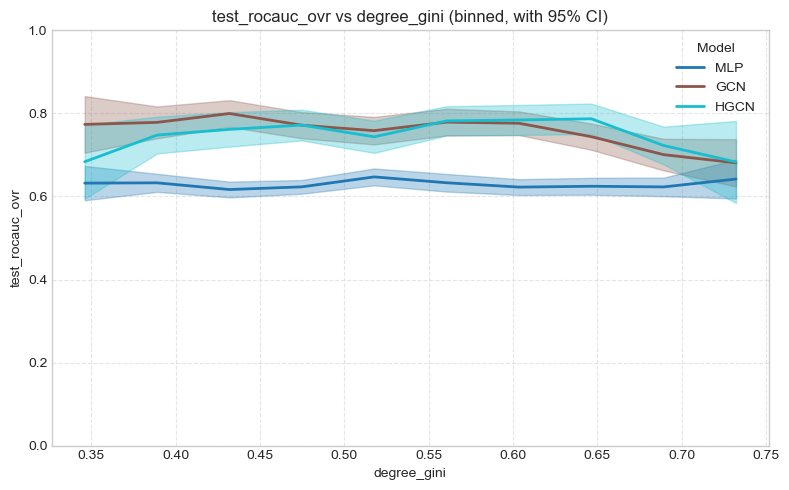

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

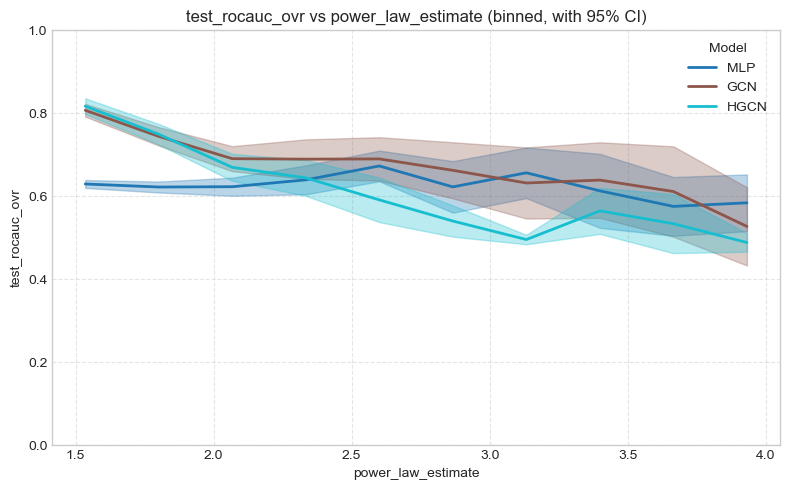

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

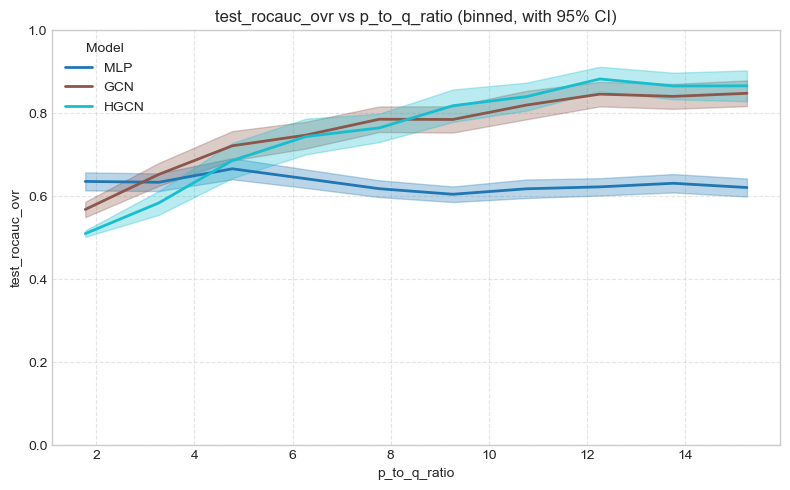

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

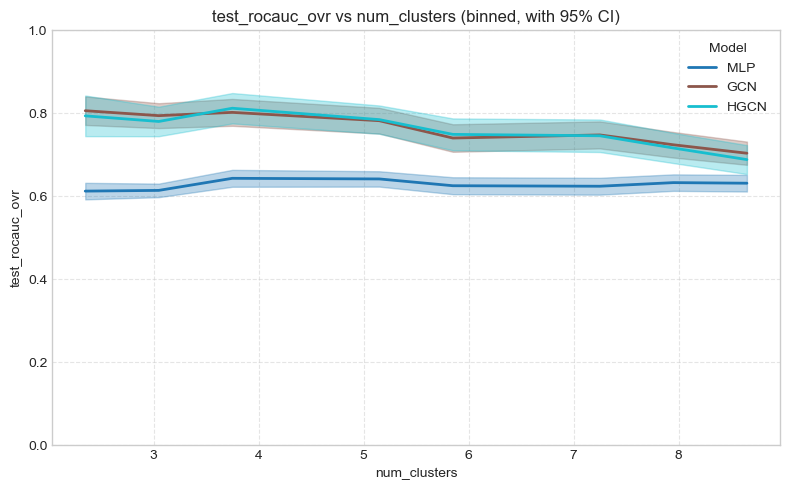

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

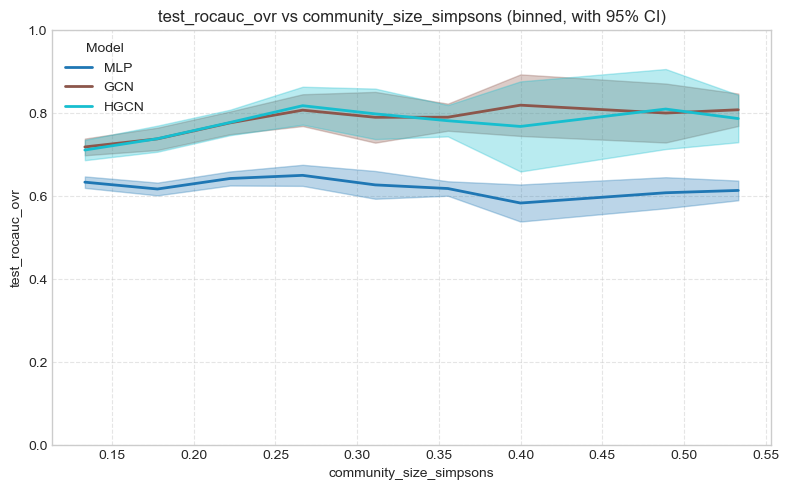

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

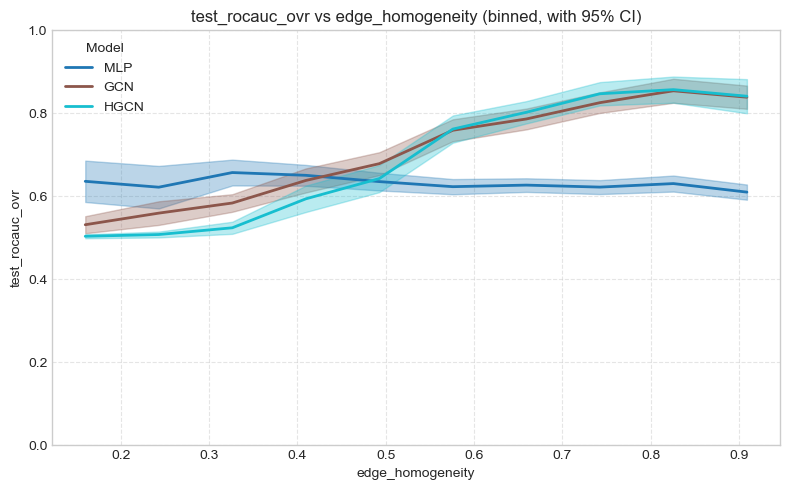

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

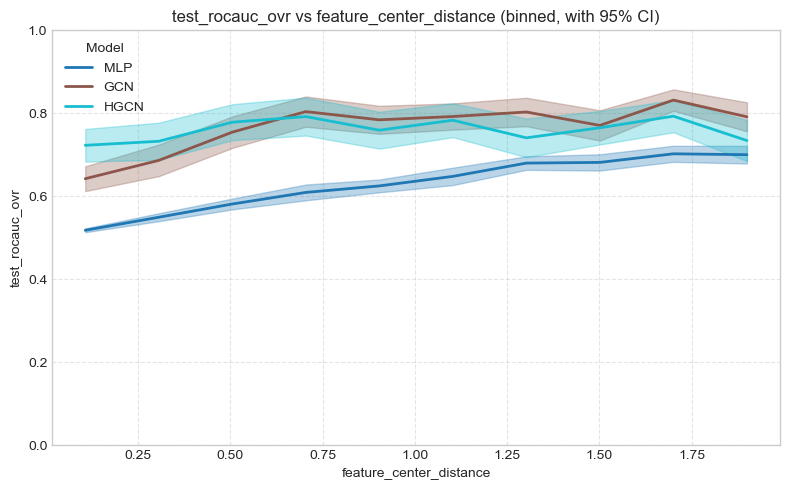

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_21401/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

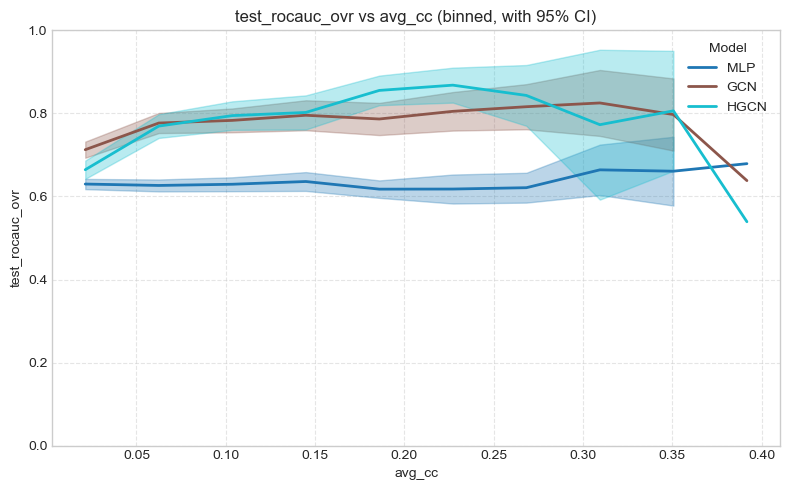

In [227]:
for m in graph_metrics_refined:
    smoothed_plot_perf_vs_metric(df, models, perf_meas = metric, metric = m)

In [ ]:
RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/test_noise_no_norm/all_model_comp/'
df16 = df_gen(RESULTS_DIR=RESULTS_DIR+'all_model_comp', NSHARDS=NSHARDS)
df2 = df_gen(RESULTS_DIR=RESULTS_DIR+'2/2', NSHARDS=NSHARDS)
df4 = df_gen(RESULTS_DIR=RESULTS_DIR+'4/4', NSHARDS=NSHARDS)
df8 = df_gen(RESULTS_DIR=RESULTS_DIR+'8/8', NSHARDS=NSHARDS)
df0 = df_gen(RESULTS_DIR = '../../graph_gen/snellius_gen/sample_gen/sample_gen/', NSHARDS = NSHARDS) 
df32 = df_gen(RESULTS_DIR = RESULTS_DIR + '32/32', NSHARDS = NSHARDS) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

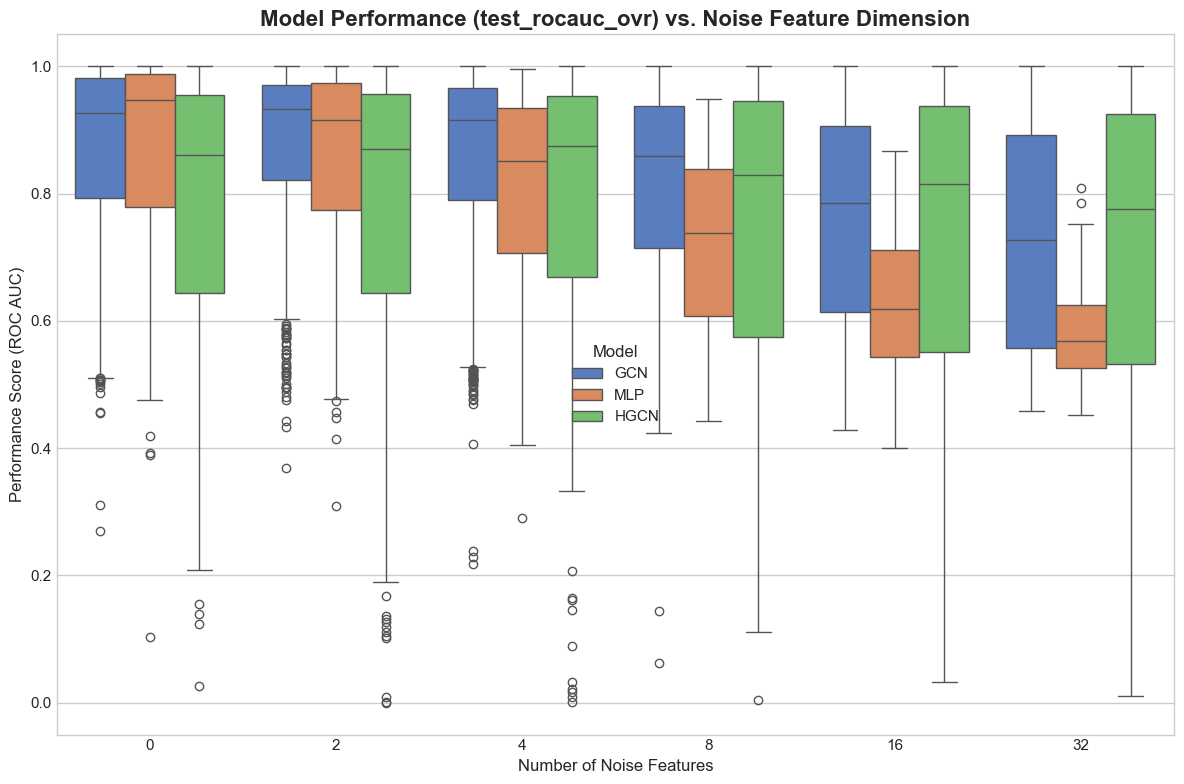

In [279]:
models = ['GCN', 'MLP', 'HGCN']
metric = 'test_rocauc_ovr'
noise_feature_dims = [0, 2, 4, 8, 16, 32]
dfs = [df0, df2, df4, df8, df16, df32]

def plot_model_perf_vs_feature_noise_dim(dfs, models, metric, noise_feature_dims):
    plot_data = []
    for i, df in enumerate(dfs):
        # Select the metric columns for the models
        df_copy = df[[f'{model}__{metric}' for model in models]].copy()
        # Add the feature dimension column
        df_copy['feature_dim'] = noise_feature_dims[i]
        plot_data.append(df_copy)

    combined_df_wide = pd.concat(plot_data, ignore_index=True)


    # --- 3. Reshape Data from Wide to Long Format ---
    # This is the key step. We use `pd.melt` to turn the model columns
    # into rows, making the data suitable for seaborn's `hue` parameter.

    id_vars = ['feature_dim']
    value_vars = [f'{model}__{metric}' for model in models]

    combined_df_long = pd.melt(
        combined_df_wide,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='model_metric', # New column for the original column names
        value_name='performance_score' # New column for the performance values
    )

    # Clean up the model names (e.g., 'GCN__test_rocauc_ovr' -> 'GCN')
    combined_df_long['model'] = combined_df_long['model_metric'].str.replace(f'__{metric}', '', regex=False)


    # --- 4. Create the Combined Boxplot ---
    # Now we create a single plot, using `hue` to differentiate the models.

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.boxplot(
        x='feature_dim',
        y='performance_score',
        hue='model', # This tells seaborn to use different colors for each model
        data=combined_df_long,
        ax=ax,
        palette='muted' # A nice color palette
    )

    # --- 5. Customize and Show the Plot ---
    ax.set_title(f'Model Performance ({metric}) vs. Noise Feature Dimension', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Noise Features', fontsize=12)
    ax.set_ylabel('Performance Score (ROC AUC)', fontsize=12)
    ax.legend(title='Model') # Add a legend to identify the colors

    plt.tight_layout()
    plt.show()

plot_model_perf_vs_feature_noise_dim(dfs, models, metric, noise_feature_dims)

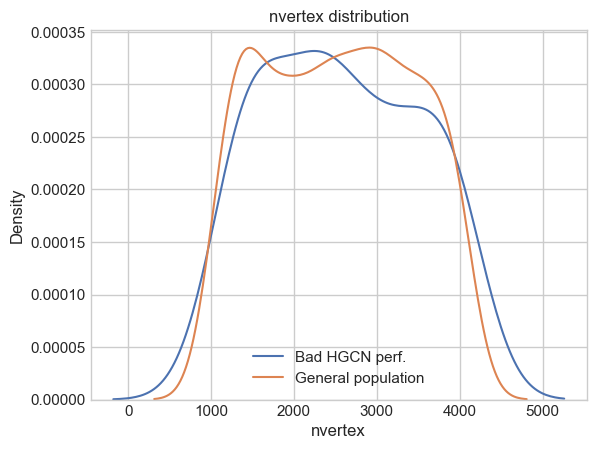

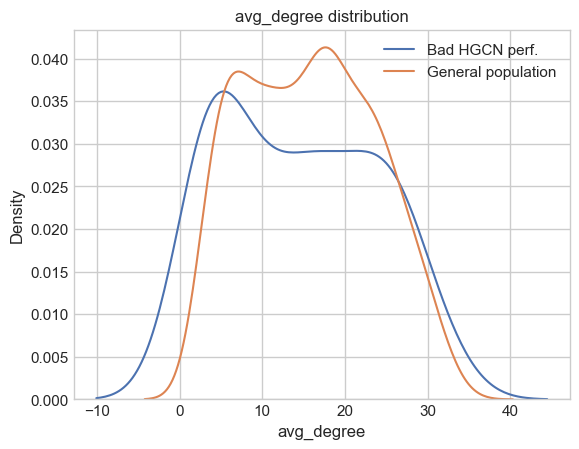

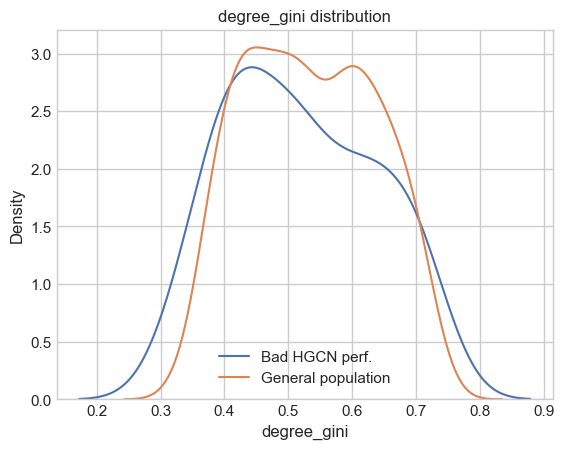

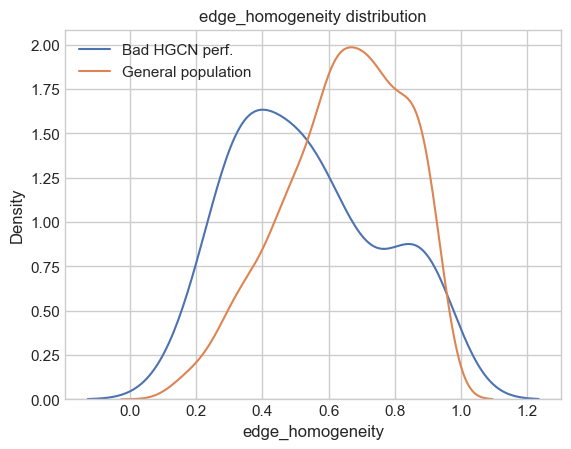

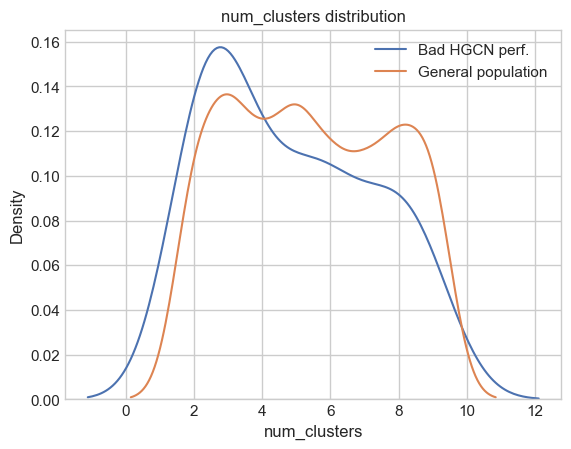

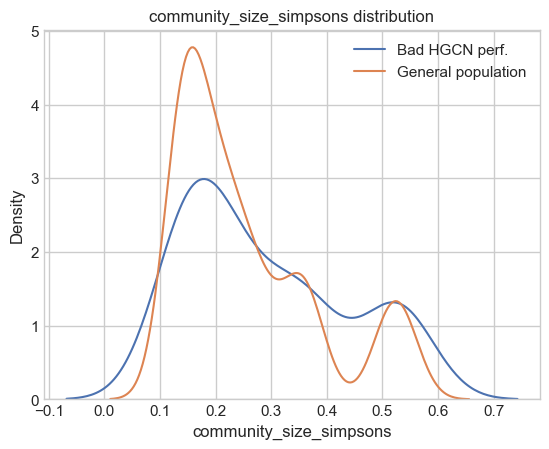

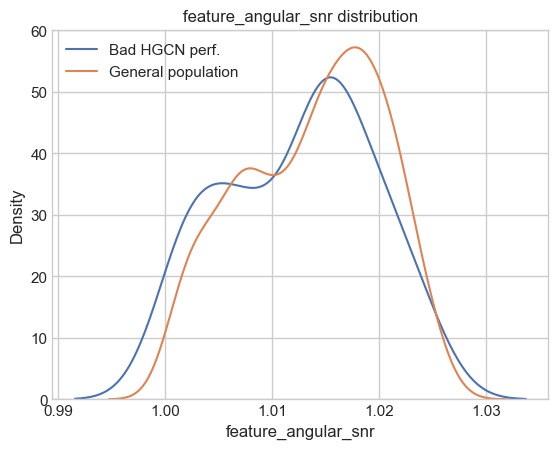

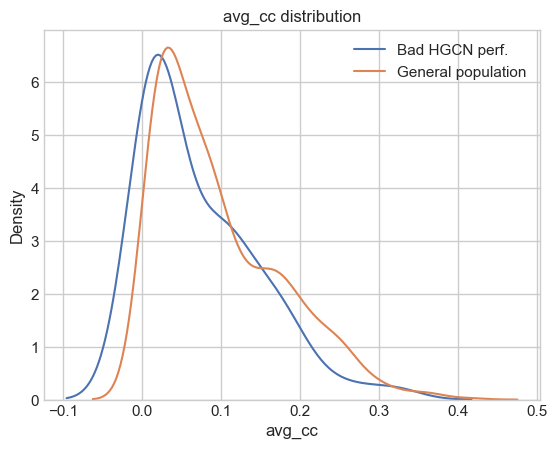

In [333]:
for m in graph_metrics_refined:
    sns.kdeplot(df16[df16['HGCN__test_rocauc_ovr']<.5][m], label = 'Bad HGCN perf.')
    sns.kdeplot(df16[m], label = 'General population')
    plt.title(f'{m} distribution')
    plt.legend()
    plt.show()

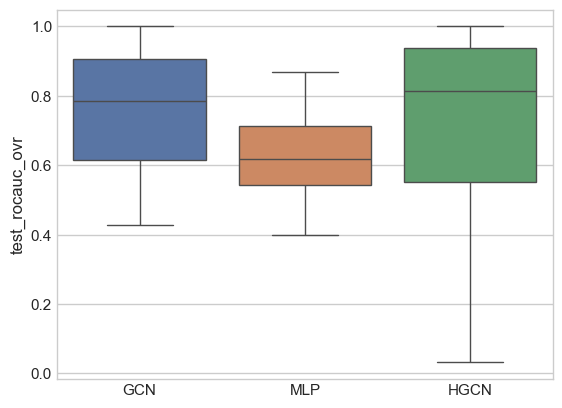

In [306]:
metric = 'test_rocauc_ovr'
df16_temp = df16[[f'{model}__{metric}' for model in models]]
df16_temp = df16_temp.rename(columns={f'{model}__{metric}':model for model in models})
sns.boxplot(df16_temp)
plt.ylabel(metric)
plt.show()

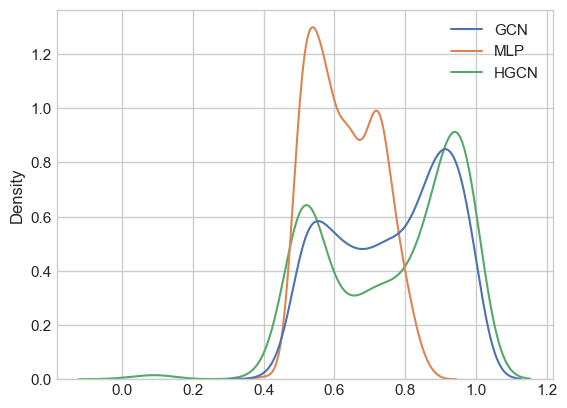

In [316]:
sns.kdeplot(df16_temp[[f'{model}' for model in models]])
plt.show()